* **Name:** Bidit Sadhukhan
* **Reg.NO:** B2230022
* **Assignment-2**: Unet Multi-Class Segmentation on COMMA Dataset(1k images)

In [1]:
!rm -r /kaggle/working/*

In [2]:
# Installing the libraries
!pip install gdown 
!pip install torch-summary

In [3]:
# Downloading the dataset from Google Drive
! gdown 1pvs-FFEiHtsTLnpDmct6p19JLvEpkmll
! unzip -qq COMMA1K.zip

Downloading...
From (original): https://drive.google.com/uc?id=1pvs-FFEiHtsTLnpDmct6p19JLvEpkmll
From (redirected): https://drive.google.com/uc?id=1pvs-FFEiHtsTLnpDmct6p19JLvEpkmll&confirm=t&uuid=e13c817e-20d6-4d2e-8f2d-e526e592aa70
To: /kaggle/working/COMMA1K.zip
100%|████████████████████████████████████████| 884M/884M [00:11<00:00, 74.3MB/s]


In [4]:
# For removing the dataset zip files 
!rm  /kaggle/working/COMMA1K.zip

In [3]:
#Importing the libraries
from matplotlib import image as mpimg
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from matplotlib import rc, rcParams
import numpy as np
import os
import sys
import cv2
import glob
import torch
import shutil
import pickle
import random
random.seed(42)
np.random.seed(42)
import torch.utils
import torchvision
from PIL import Image
from torch import optim
import torchvision.transforms as T
import torch.distributions
torch.manual_seed(42)
from tqdm import tqdm
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
# Check CUDA  and stuffs
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))
device = torch.device("cuda" if use_cuda else "cpu")
print("Device to be used : ",device)

use_cuda: True
Device to be used :  cuda


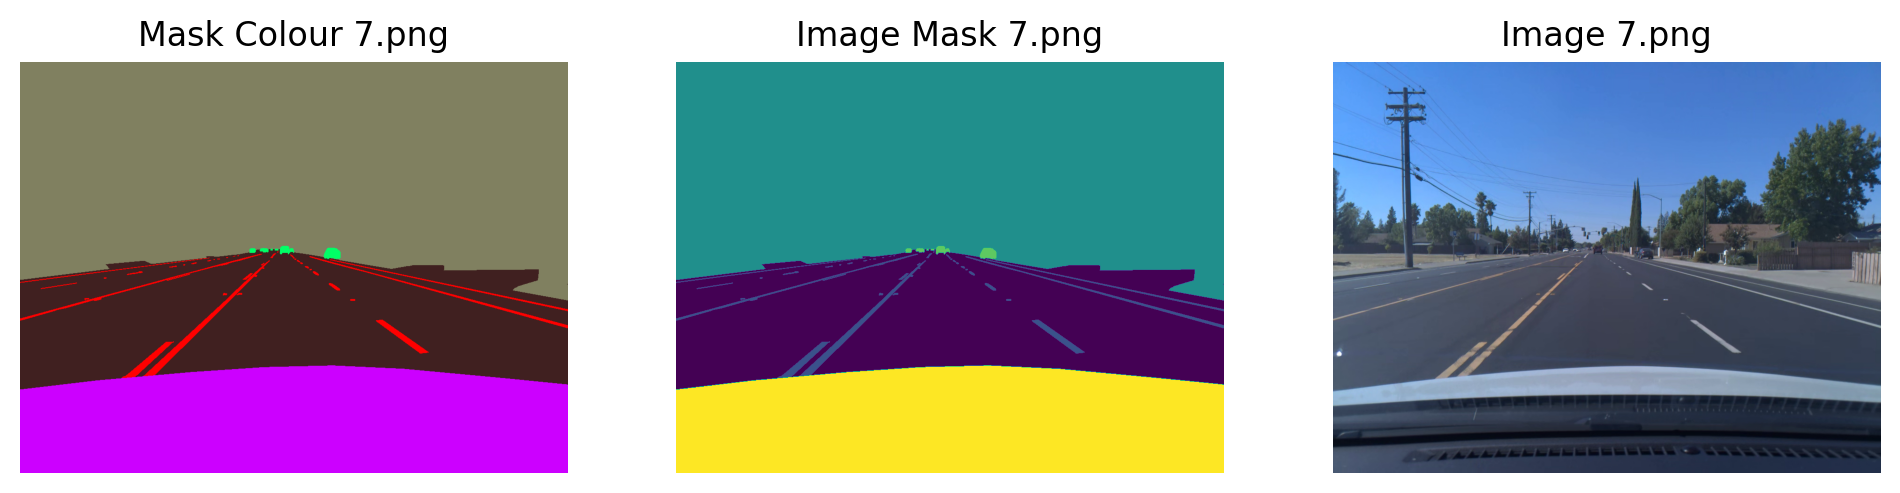

In [5]:
# plt.figure()
# fig, axes = plt.subplots(3, 1, figsize=(8, 24))
# plt.imshow('')
# plt.imshow('/kaggle/working/COMMA1K/MASKS/7.png')
# plt.imshow('/kaggle/working/COMMA1K/IMAGES/7.png')

#Visualizing the images and the masks 
# Read images
img1 = mpimg.imread('/kaggle/working/COMMA1K/MASKS_COLOR/7.png')
img2 = mpimg.imread('/kaggle/working/COMMA1K/MASKS/7.png')
img3 = mpimg.imread('/kaggle/working/COMMA1K/IMAGES/7.png')

# Setup the subplot2grid Layout
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2)) 

# Show images
ax1.imshow(img1)
ax1.axis('off')  
ax1.set_title('Mask Colour 7.png')

ax2.imshow(img2)
ax2.axis('off')
ax2.set_title('Image Mask 7.png')

ax3.imshow(img3)
ax3.axis('off') 
ax3.set_title('Image 7.png')

plt.show()

In [10]:
# Checking the colormap.txt file 
!cat /kaggle/working/COMMA1K/COLORMAP.txt

colormap = np.array([[0, 0, 0], # zeroth index
                     [64, 32, 32], # road (all parts, anywhere nobody would look at you funny for driving)
                     [255, 0, 0], # lane markings (don't include non lane markings like turn arrows and crosswalks)
                     [128, 128, 96], # undrivable
                     [0, 255, 102], # movable (vehicles and people/animals)
                     [204, 0, 255], # my car (and anything inside it, including wires, mounts, etc. No reflections)
                     [0, 204, 255], # movable in my car (people inside the car, imgsd only)
                     ])



In [6]:
# Chacking the name breakdown
image_name=glob.glob('COMMA1K/IMAGES/*.png')[1]
img = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
img_path, file_name_with_ext = os.path.split(image_name)
img_id, _ = os.path.splitext(file_name_with_ext)
print(img_id)
print(img_path)
print(image_name)

813
COMMA1K/IMAGES
COMMA1K/IMAGES/813.png


In [4]:
# Used for removing the folders which was wrongly created initially
! rm -r /kaggle/working/train_imgs /kaggle/working/val_masks /kaggle/working/train_masks /kaggle/working/test_imgs /kaggle/working/test_masks /kaggle/working/val_imgs

**Question-a**

In [4]:
# Creating the train test and val split in the ratio of 7:1:2
# Code taken from Jimut Da's Notebook Unet Segmentation tutorial

FOLDER_NAME = "train_imgs"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass

FOLDER_NAME = "val_imgs"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass

FOLDER_NAME = "test_imgs"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass

FOLDER_NAME = "train_masks"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass

FOLDER_NAME = "val_masks"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass

FOLDER_NAME = "test_masks"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass

ALL_IMAGES = glob.glob('COMMA1K/IMAGES/*.png')
train_per = 70
vali_per = 10
test_per = 20

TRAIN_IMG_NUM = int(train_per*len(ALL_IMAGES)/100)
VALID_IMG_NUM = int(vali_per*len(ALL_IMAGES)/100)
TEST_IMG_NUM = int(len(ALL_IMAGES)-(TRAIN_IMG_NUM + VALID_IMG_NUM))

print("Training images = ",TRAIN_IMG_NUM)
print("Validation images = ",VALID_IMG_NUM)
print("Test images = ",TEST_IMG_NUM)

for image_name in ALL_IMAGES[:TRAIN_IMG_NUM]:
    img = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
    img_path, file_name_with_ext = os.path.split(image_name)
    img_id, _ = os.path.splitext(file_name_with_ext)
    mask_name = "COMMA1K/MASKS/"+str(img_id)+".png"
    mask = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)
    save_img_name = "train_imgs/"+img_id+".png"
    save_mask_name = "train_masks/"+img_id+".png"
    cv2.imwrite(save_img_name,img)
    cv2.imwrite(save_mask_name,mask)

for image_name in ALL_IMAGES[TRAIN_IMG_NUM:TRAIN_IMG_NUM+VALID_IMG_NUM]:
    img = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
    img_path, file_name_with_ext = os.path.split(image_name)
    img_id, _ = os.path.splitext(file_name_with_ext)
    mask_name = "COMMA1K/MASKS/"+str(img_id)+".png"
    mask = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)
    save_img_name = "val_imgs/"+img_id+".png"
    save_mask_name = "val_masks/"+img_id+".png"
    cv2.imwrite(save_img_name,img)
    cv2.imwrite(save_mask_name,mask)

for image_name in ALL_IMAGES[TEST_IMG_NUM:]:
    img = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
    img_path, file_name_with_ext = os.path.split(image_name)
    img_id, _ = os.path.splitext(file_name_with_ext)
    mask_name = "COMMA1K/MASKS/"+str(img_id)+".png"
    mask = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)
    save_img_name = "test_imgs/"+img_id+".png"
    save_mask_name = "test_masks/"+img_id+".png"
    cv2.imwrite(save_img_name,img)
    cv2.imwrite(save_mask_name,mask)
print("------------------------------Done---------------------------")

Training images =  700
Validation images =  100
Test images =  200


KeyboardInterrupt: 

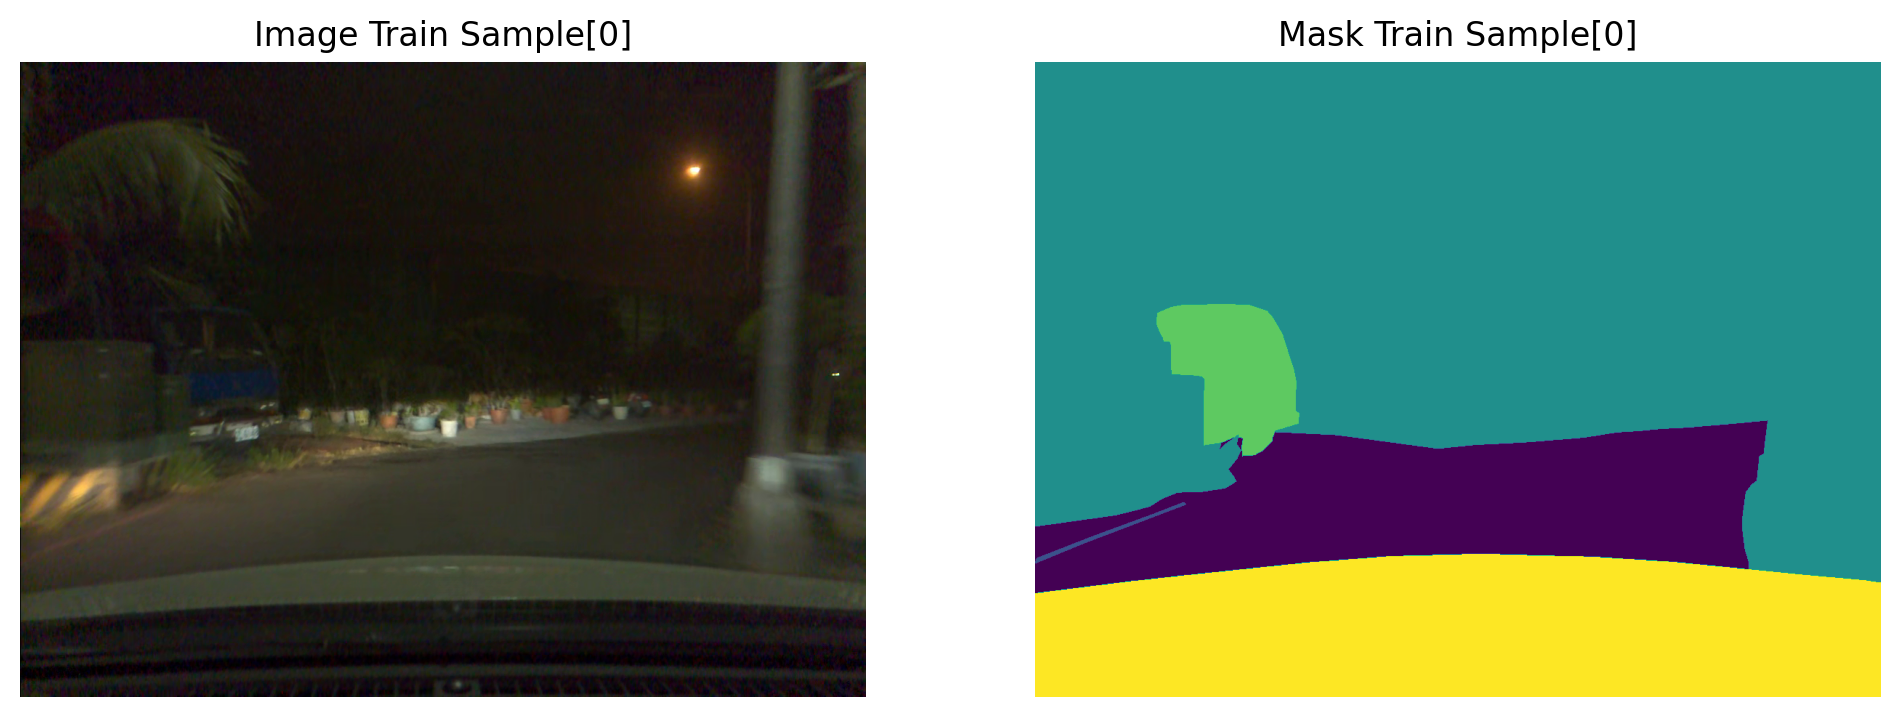

In [5]:
# Visualize the training images and the masks 
train_image_name=glob.glob('train_imgs/*.png')[0]
train_mask_name=glob.glob('train_masks/*.png')[0]
# Read images
img1 = mpimg.imread(train_image_name)
img2 = mpimg.imread(train_mask_name)
#img3 = mpimg.imread('/kaggle/working/COMMA1K/IMAGES/7.png')

# Setup the subplot2grid Layout
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
#ax3 = plt.subplot2grid((1, 3), (0, 2)) 

# Show images
ax1.imshow(img1)
ax1.axis('off')  
ax1.set_title('Image Train Sample[0]')

ax2.imshow(img2)
ax2.axis('off')
ax2.set_title('Mask Train Sample[0]')

# ax3.imshow(img3)
# ax3.axis('off') 
# ax3.set_title('Image 2')

plt.show()


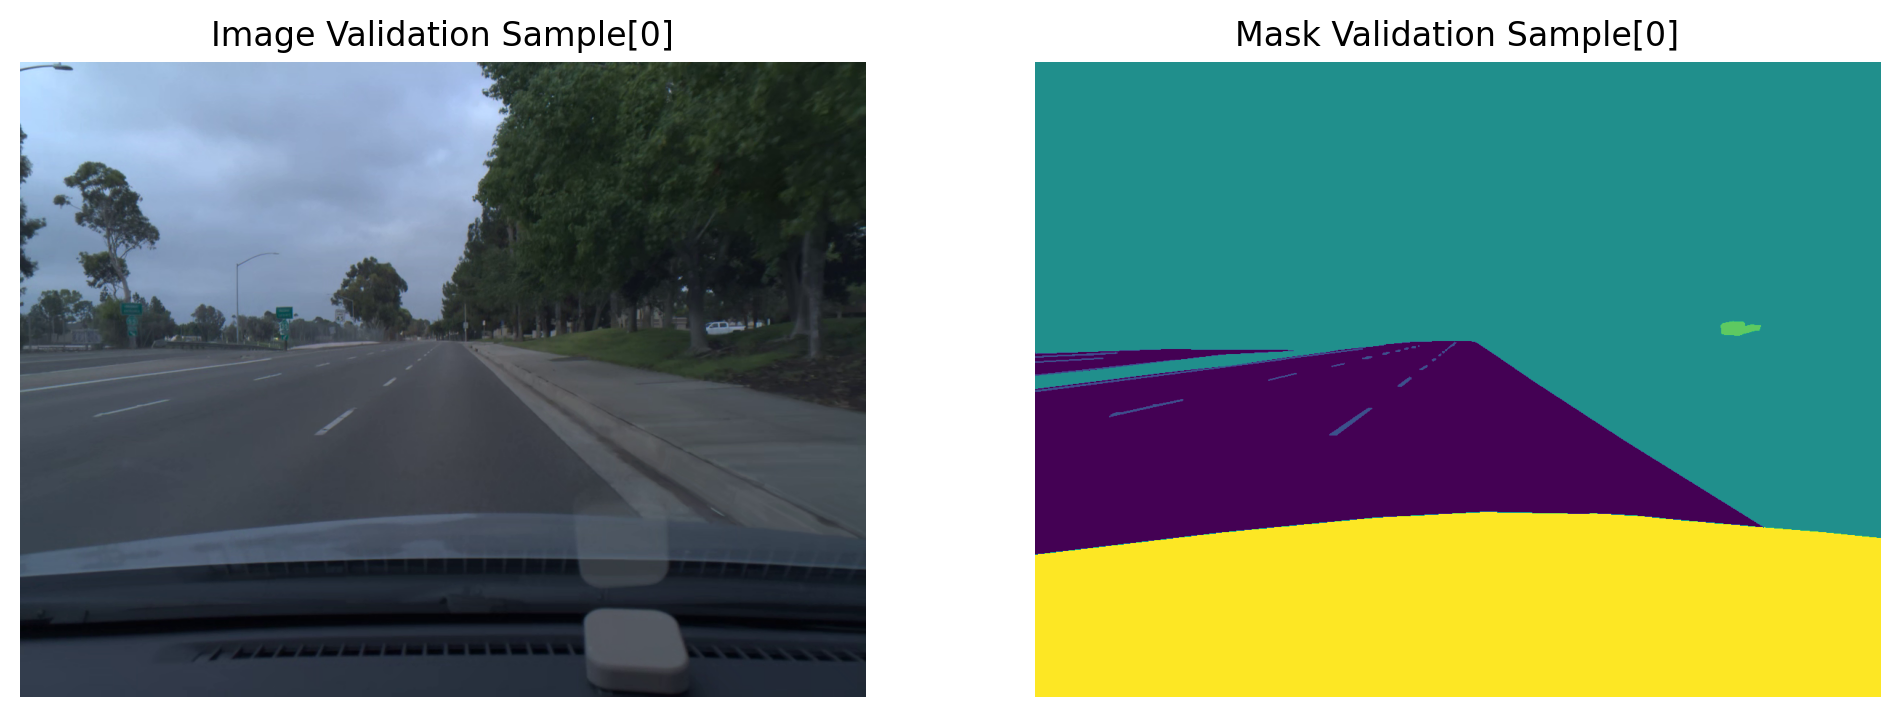

In [6]:
# Visualize the validation images and the masks 

val_image_name=glob.glob('val_imgs/*.png')[0]
val_mask_name=glob.glob('val_masks/*.png')[0]

# Read images
img1 = mpimg.imread(val_image_name)
img2 = mpimg.imread(val_mask_name)
#img3 = mpimg.imread('/kaggle/working/COMMA1K/IMAGES/7.png')

# Setup the subplot2grid Layout
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
#ax3 = plt.subplot2grid((1, 3), (0, 2)) 

# Show images
ax1.imshow(img1)
ax1.axis('off')  
ax1.set_title('Image Validation Sample[0]')

ax2.imshow(img2)
ax2.axis('off')
ax2.set_title('Mask Validation Sample[0]')

# ax3.imshow(img3)
# ax3.axis('off') 
# ax3.set_title('Image 2')

plt.show()


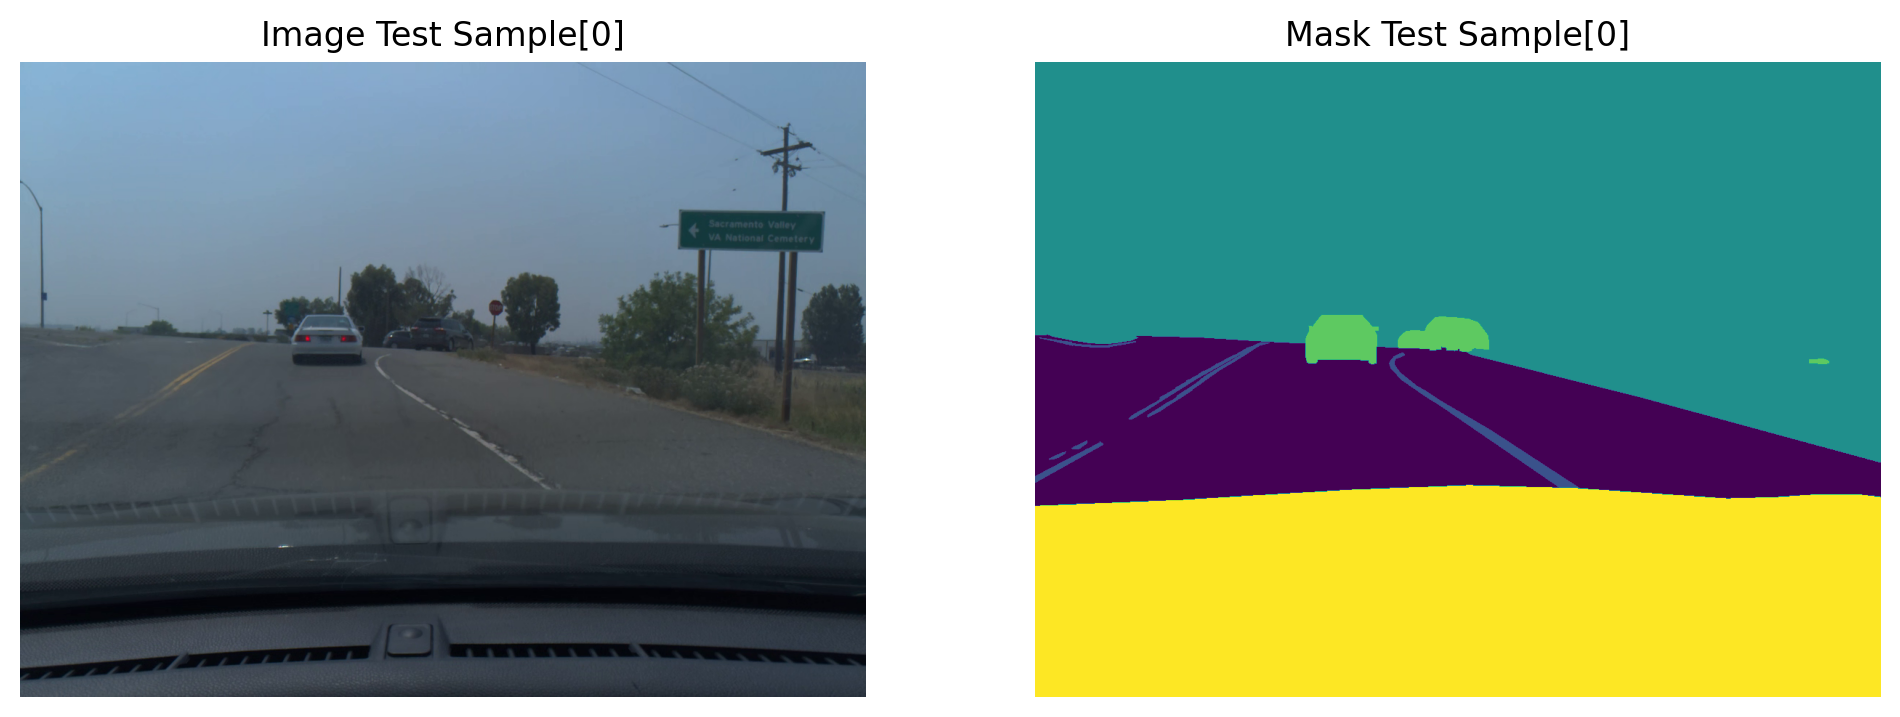

In [14]:
# Visualize the test images and the masks 
test_image_name=glob.glob('test_imgs/*.png')[0]
test_mask_name=glob.glob('test_masks/*.png')[0]

# Read images
img1 = mpimg.imread(test_image_name)
img2 = mpimg.imread(test_mask_name)
#img3 = mpimg.imread('/kaggle/working/COMMA1K/IMAGES/7.png')

# Setup the subplot2grid Layout
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
#ax3 = plt.subplot2grid((1, 3), (0, 2)) 

# Show images
ax1.imshow(img1)
ax1.axis('off')  
ax1.set_title('Image Test Sample[0]')

ax2.imshow(img2)
ax2.axis('off')
ax2.set_title('Mask Test Sample[0]')

# ax3.imshow(img3)
# ax3.axis('off') 
# ax3.set_title('Image 2')

plt.show()


In [4]:
datasets = {
    'train_imgs': 'train_imgs/*.png',
    'train_masks': 'train_masks/*.png',
    'val_imgs': 'val_imgs/*.png',
    'val_masks': 'val_masks/*.png',
    'test_imgs': 'test_imgs/*.png',
    'test_masks': 'test_masks/*.png'
}

for dataset_name, dataset_path in datasets.items():
    dataset_length = len(glob.glob(dataset_path))
    print(f"Length of {dataset_name} = {dataset_length}")

Length of train_imgs = 754
Length of train_masks = 754
Length of val_imgs = 100
Length of val_masks = 100
Length of test_imgs = 800
Length of test_masks = 800


In [5]:
# Evaluation metrics  here
########################################################################################
########################################################################################
########################################################################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances


def dice_coef(y_true, y_pred):
    smooth = 0.0001
    y_true = np.where((y_true > 0.5) & (y_true <= 1.), 1, y_true)
    y_true = np.where((y_true > 0.0) & (y_true <= 0.5), 0, y_true)
    y_pred = np.where((y_pred > 0.5) & (y_pred <= 1.), 1, y_pred)
    y_pred = np.where((y_pred > 0.0) & (y_pred <= 0.5), 0, y_pred)
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)


def jacard(y_true, y_pred):
    smooth = 0.0001
    y_true = np.where((y_true > 0.5) & (y_true <= 1.), 1, y_true)
    y_true = np.where((y_true > 0.0) & (y_true <= 0.5), 0, y_true)
    y_pred = np.where((y_pred > 0.5) & (y_pred <= 1.), 1, y_pred)
    y_pred = np.where((y_pred > 0.0) & (y_pred <= 0.5), 0, y_pred)
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union


def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,index,:,:], y_pred[:,index,:,:])
    return dice/numLabels # taking average


def jacard_multilabel(y_true, y_pred, numLabels):
    jacard_sum=0
    for index in range(numLabels):
        jacard_sum += jacard(y_true[:,index,:,:], y_pred[:,index,:,:])
    return jacard_sum/numLabels # taking average


def accuracy_check(mask, prediction):
    ims = [mask, prediction]
    np_ims = []
    for item in ims:
        if 'str' in str(type(item)):
            item = np.array(Image.open(item))
        elif 'PIL' in str(type(item)):
            item = np.array(item)
        elif 'torch' in str(type(item)):
            item = item.numpy()
        np_ims.append(item)

    compare = np.equal(np_ims[0], np_ims[1])
    accuracy = np.sum(compare)

    return accuracy/len(np_ims[0].flatten())


def accuracy_check_for_batch(masks, predictions, num_classes, batch_size):
    total_acc = 0
    for index in range(batch_size):
        total_acc += accuracy_check(masks[index], predictions[index])
    return total_acc / (batch_size * num_classes)


In [6]:
# Creating the Multiclass Dataset loader and the generator
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

colormap = np.array([[0,0,0],[64, 32, 32], [255, 0, 0], [128, 128, 96], [0, 255, 102], [204, 0, 255], [0, 204, 255]])

class DataGenerator(Dataset):
    def __init__(self, image_list, mask_path, colormap=colormap):
        self.files = image_list
        self.select_path = mask_path
        self.colormap = colormap

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx].split('/')[-1]
        mask_name = self.select_path + file_name
        img = cv2.imread(self.files[idx], cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name, cv2.IMREAD_COLOR)  # Read mask as RGB image
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        # Convert mask to class labels
        labels = self.color_to_class(mask)

        # Convert labels to one-hot encoding
        one_hot_mask = self.class_to_onehot(labels)

        # Normalize image
        img_transpose = np.transpose(img, (2, 0, 1))
        img_normalized = torch.FloatTensor(img_transpose / img_transpose.max())

        return img_normalized, torch.FloatTensor(one_hot_mask)

    def color_to_class(self, mask):
        labels = np.zeros(mask.shape[:2], dtype=np.int64)

        for i, color in enumerate(self.colormap):
            labels[np.where(np.all(mask == color, axis=-1))] = i

        return labels

    def class_to_onehot(self, mask):
        num_classes = len(self.colormap)
        one_hot = np.eye(num_classes)[mask]
        return one_hot.transpose(2, 0, 1)


class TestDataGenerator(Dataset):
    def __init__(self, image_list, mask_path, colormap):
        self.files = image_list
        self.select_path = mask_path
        self.colormap = colormap

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx].split('/')[-1]
        mask_name = self.select_path + file_name
        img = cv2.imread(self.files[idx], cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name, cv2.IMREAD_COLOR)  # Read mask as RGB image
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        # Convert mask to class labels
        labels = self.color_to_class(mask)

        # Convert labels to one-hot encoding
        one_hot_mask = self.class_to_onehot(labels)

        # Normalize image
        img_transpose = np.transpose(img, (2, 0, 1))
        img_normalized = torch.FloatTensor(img_transpose / img_transpose.max())

        return img_normalized, torch.FloatTensor(one_hot_mask)

    def color_to_class(self, mask):
        labels = np.zeros(mask.shape[:2], dtype=np.int64)

        for i, color in enumerate(self.colormap):
            labels[np.where(np.all(mask == color, axis=-1))] = i

        return labels

    def class_to_onehot(self, mask):
        num_classes = len(self.colormap)
        one_hot = np.eye(num_classes)[mask]
        return one_hot.transpose(2, 0, 1)


In [7]:
def load_data(image_list, mask_path, batch_size=2, num_workers=10, shuffle=True):
    dataset = DataGenerator(image_list, mask_path)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return data_loader

def load_test_data(image_list, mask_path, batch_size=2, num_workers=10, shuffle=True):
    dataset = TestDataGenerator(image_list, mask_path)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return data_loader

def get_image_address(image_data_folder):
    image_address_list = []
    image_address_list = glob.glob(image_data_folder+"/*.png")
    print("Number of Files : ", len(image_address_list))
    for img_addr in image_address_list:
        try :
            img = cv2.imread(img_addr)
            x = img.shape
        except :
            image_address_list.remove(img_addr)
            os.remove(img_addr)
    print("Number of Files after removing : ", len(image_address_list))
    return image_address_list

In [6]:
# # Creating the Multiclass Dataset loader and the generator
# NUM_LABELS = 6
# # Creating the colormap array from the given colormap.txt file
# colormap = np.array([[64, 32, 32], [255, 0, 0], [128, 128, 96], [0, 255, 102], [204, 0, 255], [0, 204, 255]])

# # Extracting the labels from the colormap
# def color_to_class(mask, colormap):
#     labels = np.zeros(mask.shape[:2], dtype=np.int64)

#     for i, color in enumerate(colormap):
#         labels[np.where(np.all(mask == color, axis=-1))] = i

#     return labels

# # Converting the labels to one hot representation
# def class_to_onehot(mask, num_classes):
#     one_hot = np.eye(num_classes)[mask]
#     return one_hot.transpose(2, 0, 1)


# # Creating the dataset loader class
# class DataGenerator(Dataset):
#     def __init__(self, image_list, mask_path):
#         self.files = image_list
#         self.select_path = mask_path

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         file_name = self.files[idx].split('/')[-1]
#         mask_name = self.select_path + file_name
#         img = cv2.imread(self.files[idx], cv2.IMREAD_COLOR)
#         mask = cv2.imread(mask_name, cv2.IMREAD_COLOR)
#         img = cv2.resize(img, (256, 256))
#         mask = cv2.resize(mask, (256, 256))

#         labels = color_to_class(mask, colormap)
#         mask = class_to_onehot(labels, len(colormap))

#         img = np.transpose(img, (2, 0, 1)) / 255.0  # normalize image to range [0, 1]

#         return torch.FloatTensor(img), torch.FloatTensor(mask)

# # creating the test dataset loader and the generator class

# class TestDataGenerator(Dataset):
#     def __init__(self, image_list, mask_path):
#         self.files = image_list
#         self.select_path = mask_path

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         file_name = self.files[idx].split('/')[-1]
#         mask_name = self.select_path + file_name
#         img = cv2.imread(self.files[idx], cv2.IMREAD_COLOR)
#         mask = cv2.imread(mask_name, cv2.IMREAD_COLOR)
#         img = cv2.resize(img, (256, 256))
#         mask = cv2.resize(mask, (256, 256))
        
#         labels = color_to_class(mask, colormap)
#         mask = class_to_onehot(labels, len(colormap))

#         img = np.transpose(img, (2, 0, 1)) / 255.0  # normalize image

#         print("Unique values of image: ",np.unique(img))

#         return torch.FloatTensor(img), torch.FloatTensor(mask)


In [7]:
# # Creating the load_dataset function and the get_image_address function from the Jimut Da's Notebook 
# # Unet Segmentation Tutorial

# def load_data(image_list, mask_path, batch_size=2, num_workers=10, shuffle=True):
#     dataset = DataGenerator(image_list, mask_path)
#     data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
#     return data_loader

# def load_test_data(image_list, mask_path, batch_size=2, num_workers=10, shuffle=True):
#     dataset = TestDataGenerator(image_list, mask_path)
#     data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
#     return data_loader

# def get_image_address(image_data_folder):
#     image_address_list = []
#     image_address_list = glob.glob(image_data_folder+"/*.png")
#     print("Number of Files : ", len(image_address_list))
#     for img_addr in image_address_list:
#         try :
#             img = cv2.imread(img_addr)
#             x = img.shape
#         except :
#             image_address_list.remove(img_addr)
#             os.remove(img_addr)
#     print("Number of Files after removing : ", len(image_address_list))
#     return image_address_list

In [10]:
# Standard Unet segmentation model with torch.cat  for multiclass segmentation

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [11]:
# Use the summary function to check the structure of the network and amount of parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_standard = UNet(num_classes=7).to(device) 
summary(model_standard, input_size=(3, 256, 256)) 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      590,080
|    └─BatchNorm2d: 2-17                 512
|    └─ReLU: 2-18                      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      590,080
|    └─BatchNorm2d: 2-17                 512
|    └─ReLU: 2-18                      

In [8]:
# Unet Model without the torch.cat part that is concatenation
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet_Autoencoder(nn.Module):

    def __init__(self, num_classes):
        super(UNet_Autoencoder, self).__init__()
        self.num_classes = num_classes
        
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(512, 256)
        self.dconv_up2 = double_conv(256, 128)
        self.dconv_up1 = double_conv(128, 64)

        self.conv_last = nn.Conv2d(64, num_classes, 1)  # output layer has n_class feature maps

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)
        x = self.upsample(x)

        x = self.dconv_up3(x)
        x = self.upsample(x)

        x = self.dconv_up2(x)
        x = self.upsample(x)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out  # apply softmax to the output layer


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_autoencode = UNet_Autoencoder(num_classes=7).to(device)

summary(model_autoencode, input_size =(3, 256, 256)) 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      590,080
|    └─BatchNorm2d: 2-17                 512
|    └─ReLU: 2-18                      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      590,080
|    └─BatchNorm2d: 2-17                 512
|    └─ReLU: 2-18                      

In [18]:
# Creating the dump folders taken from the Jimut Da's Unet Segmentation Tutorial Notebook
FOLDER_NAME = "checkpoint"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass


FOLDER_NAME = "inference_data"


try:
    os.makedirs(FOLDER_NAME)
except:
    pass


FOLDER_NAME = "history"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass


In [15]:
# Saving the Model Checkpoint and the results
# save checkpoint in pytorch
def save_ckp(checkpoint, checkpoint_path):
    torch.save(checkpoint, checkpoint_path)


# load checkpoint in pytorch
def load_ckp(checkpoint_path, model, model_opt):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model_opt.load_state_dict(checkpoint['optimizer'])
    return model, model_opt, checkpoint['epoch']


In [16]:
!rm -r /kaggle/working/checkpoint /kaggle/working/history /kaggle/working/inference_data

In [13]:
num_classes=7
def train_epoch(train_loader, model, optimizer, epoch):
    print("\n\n---------------------------------------------------------------------------------------------------------------\n")

    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_jacard = 0.0
    total_acc = 0.0
    N = 0
    num_classes = model.num_classes  # Get the number of classes from the model

    for step, (inp__, gt__) in progress_bar:
        model.train()

        # Transferring data to device
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        # Clear the gradient
        optimizer.zero_grad()

        # Getting the predicted image
        pred_img = model.forward(inp__)

        # Loss functions
        CE_loss = nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multiclass segmentation

        # Reshaping ground truth mask to match the shape of predicted mask
        gt_one_hot = gt__.argmax(dim=1)  # Convert one-hot encoding to categorical
        gt_one_hot = gt_one_hot.long()  # Ensure ground truth is LongTensor for CrossEntropyLoss

        # Calculating loss
        loss = CE_loss(pred_img, gt_one_hot)

        # Calculating metrics
        total_loss += loss.item()  # Use loss.item() to get the scalar value of the loss
        pred_img_detached = pred_img.cpu().detach().numpy()
        gt_img_detached = gt__.cpu().detach().numpy()

        dice = dice_coef_multilabel(gt_img_detached, pred_img_detached, num_classes)
        jacard_ = jacard_multilabel(gt_img_detached, pred_img_detached, num_classes)
        acc_ = accuracy_check_for_batch(np.round(pred_img_detached), gt_img_detached, num_classes, pred_img_detached.shape[0])

        total_dice += dice
        total_jacard += jacard_
        total_acc += acc_
        N += 1

        # Backpropagating the loss
        loss.backward()
        optimizer.step()

        # Displaying the loss
        progress_bar.set_description("Epoch: {} -  Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss.item(), acc_, dice, jacard_))

    mean_loss = total_loss / N
    mean_dice = total_dice / N
    mean_jacard = total_jacard / N
    mean_acc = total_acc / N

    with open("history/train_logs.txt", "a") as text_file:
        text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))
    print("[Training] Training Epoch: {} |  Loss: {} | Acc: {} | Dice: {} | Jaccard: {}".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))

    return model, optimizer



def val_epoch(val_loader, model, optimizer, epoch):
    progress_bar = tqdm(enumerate(val_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_jacard = 0.0
    total_acc = 0.0
    N = 0
    num_classes = model.num_classes  # Get the number of classes from the model

    for step, (inp__, gt__) in progress_bar:
        if inp__ is None and gt__ is None:
            continue

        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        model.eval()
        pred_img = model.forward(inp__)

        # Loss functions
        CE_loss = nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multiclass segmentation

        # Reshaping ground truth mask to match the shape of predicted mask
        gt_one_hot = gt__.argmax(dim=1)  # Convert one-hot encoding to categorical
        gt_one_hot = gt_one_hot.long()  # Ensure ground truth is LongTensor for CrossEntropyLoss

        # Calculating loss
        loss = CE_loss(pred_img, gt_one_hot)

        # Calculating metrics
        total_loss += loss.item()  # Use loss.item() to get the scalar value of the loss
        pred_img_detached = pred_img.cpu().detach().numpy()
        gt_img_detached = gt__.cpu().detach().numpy()

        dice = dice_coef_multilabel(gt_img_detached, pred_img_detached, num_classes)
        jacard_ = jacard_multilabel(gt_img_detached, pred_img_detached, num_classes)
        acc_ = accuracy_check_for_batch(np.round(pred_img_detached), gt_img_detached, num_classes, pred_img_detached.shape[0])

        total_dice += dice
        total_jacard += jacard_
        total_acc += acc_
        N += 1

        progress_bar.set_description("Epoch: {} -  Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss.item(), acc_, dice, jacard_))

    mean_loss = total_loss / N
    mean_dice = total_dice / N
    mean_jacard = total_jacard / N
    mean_acc = total_acc / N

    with open("history/val_logs.txt", "a") as text_file:
        text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))

    print("[Validation] Validation Epoch: {} |  Loss: {} | Acc: {} | Dice: {} | Jaccard: {}".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))

def test_epoch(test_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0

    #SETTING THE NUMBER OF IMAGES TO CHECK AFTER EACH ITERATION
    no_img_to_write = 20

    total_loss = 0.0
    total_dice = 0.0
    total_jacard = 0.0
    total_acc = 0.0
    N = 0
    num_classes = model.num_classes 
    for step, (inp__, gt__) in progress_bar:
        if inp__ is None and gt__ is None:
            continue

        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        model.eval()
        pred_img = model.forward(inp__)

        # Loss functions
        CE_loss = nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multiclass segmentation

        # Reshaping ground truth mask to match the shape of predicted mask
        gt_one_hot = gt__.argmax(dim=1)  # Convert one-hot encoding to categorical
        gt_one_hot = gt_one_hot.long()  # Ensure ground truth is LongTensor for CrossEntropyLoss

        # Calculating loss
        loss = CE_loss(pred_img, gt_one_hot)

        # Calculating metrics
        total_loss += loss.item()  # Use loss.item() to get the scalar value of the loss
        pred_img_detached = pred_img.cpu().detach().numpy()
        gt_img_detached = gt__.cpu().detach().numpy()

        dice = dice_coef_multilabel(gt_img_detached, pred_img_detached, num_classes)
        jacard_ = jacard_multilabel(gt_img_detached, pred_img_detached, num_classes)
        acc_ = accuracy_check_for_batch(np.round(pred_img_detached), gt_img_detached, num_classes, pred_img_detached.shape[0])

        total_dice += dice
        total_jacard += jacard_
        total_acc += acc_
        N += 1

        # Displaying the loss
        progress_bar.set_description("[Test] Epoch: {} -  Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss.item(), acc_, dice, jacard_))
        print("Shape of predicted image:", pred_img_detached.shape)
        print("Shape of ground truth image:", gt_img_detached.shape)

        #WRITING THE IMAGES INTO THE SPECIFIED DIRECTORY
#         if step < no_img_to_write:
#             # Convert prediction to colored segmentation mask using provided colormap
#             pred_seg_mask = np.argmax(pred_img_detached, axis=1)
            #pred_colored_mask = colorize_mask(pred_seg_mask)

            # Convert ground truth to colored segmentation mask using provided colormap
            #gt_colored_mask = colorize_mask(gt_img_detached)

            # Save images
            #save_images(pred_colored_mask, gt_colored_mask, inp__, step, epoch)

    mean_loss = total_loss / N
    mean_dice = total_dice / N
    mean_jacard = total_jacard / N
    mean_acc = total_acc / N

    with open("history/test_logs.txt", "a") as text_file:
        text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))

    print("Test Epoch: {} |  Loss: {} | Accuracy: {} | Dice: {} | Jaccard: {}".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))
    print("---------------------------------------------------------------------------------------------------------------")

def colorize_mask(mask):
    # Define colormap
    colormap = {
        0: [0, 0, 0],       # Background
        1: [64, 32, 32],    # Road
        2: [255, 0, 0],     # Lane markings
        3: [128, 128, 96],  # Undrivable
        4: [0, 255, 102],   # Movable
        5: [204, 0, 255],   # My car
        6: [0, 204, 255]    # Movable in my car
    }

    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Apply colormap
    for label, color in colormap.items():
        colored_mask[mask == label] = color

    return colored_mask

def save_images(pred_colored_mask, gt_colored_mask, inp__, step, epoch):
    inference_folder = "inference_data"
    if not os.path.isdir(inference_folder):
        os.mkdir(inference_folder)

    # Save predicted and ground truth images
    cv2.imwrite(os.path.join(inference_folder, "img_" + str(step) + "_pred_epoch_" + str(epoch) + ".png"), pred_colored_mask)
    cv2.imwrite(os.path.join(inference_folder, "img_" + str(step) + "_gt_epoch_" + str(epoch) + ".png"), gt_colored_mask)

    # Save input image
    inp_img = np.transpose(inp__[0].cpu().numpy(), (1, 2, 0))  # Get the first input image from the batch
    cv2.imwrite(os.path.join(inference_folder, "img_" + str(step) + "_inp_epoch_" + str(epoch) + ".png"), inp_img)


In [14]:
def train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume):

    #PATH TO SAVE THE CHECKPOINT
    checkpoint_path = "checkpoint/checkpoint.pt"

    epoch = 0
    #IF TRAINING IS TO RESUMED FROM A CERTAIN CHECKPOINT
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while epoch <= n_epoch:
        epoch += 1
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch)

        #CHECKPOINT CREATION
        checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}

        #CHECKPOINT SAVING
        save_ckp(checkpoint, checkpoint_path)
        print("Checkpoint Saved")

        #CHECKPOINT LOADING
        model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
        print("Checkpoint Loaded")
        with torch.no_grad():
            val_epoch(val_loader, model, optimizer, epoch)

    print("************************ Final Test Epoch *****************************")

    with torch.no_grad():
        test_epoch(test_loader, model, optimizer, epoch)

In [40]:
import os

os.chdir('/kaggle/working/') 
print(os.getcwd())
train_image_address_list = get_image_address("train_imgs/")
random.shuffle(train_image_address_list)
print(train_image_address_list)

/kaggle/working
Number of Files :  700
Number of Files after removing :  700
['train_imgs/139.png', 'train_imgs/263.png', 'train_imgs/188.png', 'train_imgs/343.png', 'train_imgs/427.png', 'train_imgs/48.png', 'train_imgs/838.png', 'train_imgs/96.png', 'train_imgs/986.png', 'train_imgs/815.png', 'train_imgs/534.png', 'train_imgs/845.png', 'train_imgs/756.png', 'train_imgs/891.png', 'train_imgs/462.png', 'train_imgs/940.png', 'train_imgs/459.png', 'train_imgs/678.png', 'train_imgs/886.png', 'train_imgs/351.png', 'train_imgs/538.png', 'train_imgs/873.png', 'train_imgs/981.png', 'train_imgs/222.png', 'train_imgs/21.png', 'train_imgs/948.png', 'train_imgs/551.png', 'train_imgs/410.png', 'train_imgs/321.png', 'train_imgs/194.png', 'train_imgs/824.png', 'train_imgs/347.png', 'train_imgs/161.png', 'train_imgs/737.png', 'train_imgs/988.png', 'train_imgs/504.png', 'train_imgs/507.png', 'train_imgs/563.png', 'train_imgs/929.png', 'train_imgs/872.png', 'train_imgs/595.png', 'train_imgs/143.png', '

In [15]:
def main():

    train_image_address_list = get_image_address("train_imgs/")
    random.shuffle(train_image_address_list)

    train_loader = load_data(train_image_address_list, mask_path="train_masks/", batch_size=2, num_workers=2, shuffle=True)
    check = iter(train_loader)
    val_image_address_list = get_image_address("val_imgs/")

    random.shuffle(val_image_address_list)
    val_loader = load_data(val_image_address_list, mask_path="val_masks/", batch_size=2, num_workers=2, shuffle=True)
    check = iter(val_loader)

    test_image_address_list = get_image_address("test_imgs/")
    random.shuffle(test_image_address_list)
    test_loader = load_data(test_image_address_list, mask_path="test_masks/", batch_size=2, num_workers=2, shuffle=True)
    check = iter(test_loader)

    print("Train : {} Val : {} ".format(len(train_image_address_list), len(val_image_address_list)))

    #1. CALLING THE MODEL - U-Net, batch_size=2, num_workers=2, lr=1e-04
    model = UNet(7)
    model = model.to(device)
    summary(model, input_size=(3, 128, 128))

    #DEFINING THE OPTIMIZER
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=1e-04, weight_decay=5e-4)

    n_epoch = 100

    #INDICATOR VARIABLE TO RESUME TRAINING OR START AFRESH
    resume = True
    train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume)


In [16]:
if __name__ == "__main__":
    print("--- Starting the main function ----")
    main()

--- Starting the main function ----
Number of Files :  754
Number of Files after removing :  754
Number of Files :  100
Number of Files after removing :  100
Number of Files :  800
Number of Files after removing :  800
Train : 754 Val : 100 
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-13          

Epoch: 27 -  Loss: 0.0024185781367123127 - Acc: 0.0 - Dice: 0.2334145742739622 - Jaccard: 0.6375740596226284: : 377it [00:34, 10.93it/s] 


[Training] Training Epoch: 27 |  Loss: 0.002553726571787455 | Acc: 0.0 | Dice: 0.23295851418157584 | Jaccard: 0.6308537302888131
Checkpoint Saved
Checkpoint Loaded


Epoch: 28 -  Loss: 0.001706325332634151 - Acc: 0.0 - Dice: 0.23524067726451853 - Jaccard: 0.6658095632280622: : 50it [00:03, 14.88it/s] 

[Validation] Validation Epoch: 28 |  Loss: 0.0019312982610426843 | Acc: 0.0 | Dice: 0.23452751319433346 | Jaccard: 0.6547426468985422


---------------------------------------------------------------------------------------------------------------




Epoch: 29 -  Loss: 0.0019576360937207937 - Acc: 0.0 - Dice: 0.2343113102752349 - Jaccard: 0.651188850402832: : 377it [00:33, 11.32it/s]  


[Training] Training Epoch: 29 |  Loss: 0.0022117594579378 | Acc: 0.0 | Dice: 0.23374679331292414 | Jaccard: 0.6426227070156849
Checkpoint Saved
Checkpoint Loaded


Epoch: 30 -  Loss: 0.0019638994708657265 - Acc: 0.0 - Dice: 0.2339781240725358 - Jaccard: 0.6460751124790737: : 50it [00:03, 14.88it/s] 

[Validation] Validation Epoch: 30 |  Loss: 0.0019411780638620257 | Acc: 0.0 | Dice: 0.2340199932078918 | Jaccard: 0.6467231954847064


---------------------------------------------------------------------------------------------------------------




Epoch: 31 -  Loss: 0.0016497394535690546 - Acc: 0.0 - Dice: 0.2353593866479974 - Jaccard: 0.6677159581865583: : 377it [00:33, 11.21it/s] 


[Training] Training Epoch: 31 |  Loss: 0.0018520462823863727 | Acc: 0.0 | Dice: 0.23466323617677576 | Jaccard: 0.6567235121269845
Checkpoint Saved
Checkpoint Loaded


Epoch: 32 -  Loss: 0.002243728842586279 - Acc: 0.0 - Dice: 0.23286568463596272 - Jaccard: 0.6294684410095215: : 50it [00:03, 14.97it/s] 

[Validation] Validation Epoch: 32 |  Loss: 0.0018646123772487044 | Acc: 0.0 | Dice: 0.234584908349674 | Jaccard: 0.655581716809954


---------------------------------------------------------------------------------------------------------------




Epoch: 33 -  Loss: 0.0016502018552273512 - Acc: 0.0 - Dice: 0.23432935749019876 - Jaccard: 0.6514677320207868: : 377it [00:33, 11.29it/s]                  


[Training] Training Epoch: 33 |  Loss: 0.00174792462049561 | Acc: 5.410332288170573e-08 | Dice: 0.23500021679703698 | Jaccard: 0.6622136093622452
Checkpoint Saved
Checkpoint Loaded


Epoch: 34 -  Loss: 0.0018511374946683645 - Acc: 0.0 - Dice: 0.23317094958937967 - Jaccard: 0.6339554786682129: : 50it [00:03, 13.98it/s]

[Validation] Validation Epoch: 34 |  Loss: 0.0018215790670365094 | Acc: 0.0 | Dice: 0.23332344176953376 | Jaccard: 0.6362367466517856


---------------------------------------------------------------------------------------------------------------




Epoch: 35 -  Loss: 0.0012310647871345282 - Acc: 0.0 - Dice: 0.23659018647781258 - Jaccard: 0.6880247933523995: : 377it [00:32, 11.44it/s]


[Training] Training Epoch: 35 |  Loss: 0.001425927409479785 | Acc: 0.0 | Dice: 0.23575072507407402 | Jaccard: 0.6742171834661634
Checkpoint Saved
Checkpoint Loaded


Epoch: 36 -  Loss: 0.0013301568105816841 - Acc: 0.0 - Dice: 0.23604761307886357 - Jaccard: 0.678947993687221: : 50it [00:03, 15.33it/s] 

[Validation] Validation Epoch: 36 |  Loss: 0.0012943964055739344 | Acc: 0.0 | Dice: 0.23628918100978136 | Jaccard: 0.682986113684518


---------------------------------------------------------------------------------------------------------------




Epoch: 37 -  Loss: 0.001173048629425466 - Acc: 0.0 - Dice: 0.23704297009022485 - Jaccard: 0.6957543918064663: : 377it [00:32, 11.43it/s] 


[Training] Training Epoch: 37 |  Loss: 0.0012367506568945095 | Acc: 0.0 | Dice: 0.23675023033813147 | Jaccard: 0.6907687582902812
Checkpoint Saved
Checkpoint Loaded


Epoch: 38 -  Loss: 0.001031341147609055 - Acc: 0.0 - Dice: 0.2374832634879245 - Jaccard: 0.7034099442618233: : 50it [00:03, 14.90it/s]  

[Validation] Validation Epoch: 38 |  Loss: 0.001035113134421408 | Acc: 0.0 | Dice: 0.23755865304318402 | Jaccard: 0.7047397027696881


---------------------------------------------------------------------------------------------------------------




Epoch: 39 -  Loss: 0.001043027499690652 - Acc: 0.0 - Dice: 0.23776001297940574 - Jaccard: 0.7082938466753278: : 377it [00:32, 11.42it/s] 


[Training] Training Epoch: 39 |  Loss: 0.001162876471054471 | Acc: 0.0 | Dice: 0.23722994358222074 | Jaccard: 0.6990311531552584
Checkpoint Saved
Checkpoint Loaded


Epoch: 40 -  Loss: 0.000993096735328436 - Acc: 0.0 - Dice: 0.23826779306613996 - Jaccard: 0.7174030031476702: : 50it [00:03, 14.97it/s] 

[Validation] Validation Epoch: 40 |  Loss: 0.0010315805161371827 | Acc: 0.0 | Dice: 0.23797438575783927 | Jaccard: 0.7121536145891464


---------------------------------------------------------------------------------------------------------------




Epoch: 41 -  Loss: 0.0010141480015590787 - Acc: 0.0 - Dice: 0.23809448858010893 - Jaccard: 0.7142722266060966: : 377it [00:33, 11.42it/s]


[Training] Training Epoch: 41 |  Loss: 0.0011259087534937562 | Acc: 0.0 | Dice: 0.2375978974385807 | Jaccard: 0.7055026098108959
Checkpoint Saved
Checkpoint Loaded


Epoch: 42 -  Loss: 0.0009770955657586455 - Acc: 0.0 - Dice: 0.23845911614559606 - Jaccard: 0.7208859579903739: : 50it [00:03, 15.22it/s]

[Validation] Validation Epoch: 42 |  Loss: 0.0009944878902751952 | Acc: 0.0 | Dice: 0.23804954050444518 | Jaccard: 0.713492122377668


---------------------------------------------------------------------------------------------------------------




Epoch: 43 -  Loss: 0.0009297957876697183 - Acc: 0.0 - Dice: 0.2386475160537202 - Jaccard: 0.7243433679853167: : 377it [00:33, 11.39it/s] 


[Training] Training Epoch: 43 |  Loss: 0.00099233381585428 | Acc: 0.0 | Dice: 0.2382600908354609 | Jaccard: 0.7173038557109703
Checkpoint Saved
Checkpoint Loaded


Epoch: 44 -  Loss: 0.0009147472446784377 - Acc: 0.0 - Dice: 0.23847791785559247 - Jaccard: 0.7212297575814384: : 50it [00:03, 15.27it/s]

[Validation] Validation Epoch: 44 |  Loss: 0.0007569235970731825 | Acc: 0.0 | Dice: 0.23952230048665302 | Jaccard: 0.7408546366010392


---------------------------------------------------------------------------------------------------------------




Epoch: 45 -  Loss: 0.0008638114086352289 - Acc: 0.0 - Dice: 0.2394019662657689 - Jaccard: 0.7384704862322126: : 377it [00:33, 11.37it/s] 


[Training] Training Epoch: 45 |  Loss: 0.0009143425033437656 | Acc: 0.0 | Dice: 0.23900803884439276 | Jaccard: 0.7310503232926301
Checkpoint Saved
Checkpoint Loaded


Epoch: 46 -  Loss: 0.0008217094582505524 - Acc: 0.0 - Dice: 0.2399336823417718 - Jaccard: 0.748706613268171: : 50it [00:03, 15.62it/s]  

[Validation] Validation Epoch: 46 |  Loss: 0.0008281054627150297 | Acc: 0.0 | Dice: 0.23956765705958485 | Jaccard: 0.7416668006352016


---------------------------------------------------------------------------------------------------------------




Epoch: 47 -  Loss: 0.0010805389611050487 - Acc: 0.0 - Dice: 0.23874181108825362 - Jaccard: 0.7260842323303223: : 377it [00:33, 11.39it/s]


[Training] Training Epoch: 47 |  Loss: 0.0008819569076722691 | Acc: 0.0 | Dice: 0.23949495580557476 | Jaccard: 0.7402571489884118
Checkpoint Saved
Checkpoint Loaded


Epoch: 48 -  Loss: 0.0005934291984885931 - Acc: 0.0 - Dice: 0.24130941697851735 - Jaccard: 0.7763286999293736: : 50it [00:03, 15.16it/s]

[Validation] Validation Epoch: 48 |  Loss: 0.0006929250189568847 | Acc: 0.0 | Dice: 0.2406692568119217 | Jaccard: 0.7634233897072931


---------------------------------------------------------------------------------------------------------------




Epoch: 49 -  Loss: 0.0008297188323922455 - Acc: 0.0 - Dice: 0.24040471008469005 - Jaccard: 0.7579751014709473: : 377it [00:33, 11.37it/s]


[Training] Training Epoch: 49 |  Loss: 0.0008481986910556826 | Acc: 0.0 | Dice: 0.24002366384216967 | Jaccard: 0.7505010617145227
Checkpoint Saved
Checkpoint Loaded


Epoch: 50 -  Loss: 0.0008475636132061481 - Acc: 0.0 - Dice: 0.240718905632993 - Jaccard: 0.7642654691423688: : 50it [00:03, 15.01it/s]  

[Validation] Validation Epoch: 50 |  Loss: 0.0008644919097423553 | Acc: 0.0 | Dice: 0.2403983191248104 | Jaccard: 0.7579597813742501


---------------------------------------------------------------------------------------------------------------




Epoch: 51 -  Loss: 0.0007706568576395512 - Acc: 0.0 - Dice: 0.24104257932579526 - Jaccard: 0.7708381244114467: : 377it [00:32, 11.48it/s]


[Training] Training Epoch: 51 |  Loss: 0.0008677244575481753 | Acc: 0.0 | Dice: 0.2402933470294735 | Jaccard: 0.7558096673914138
Checkpoint Saved
Checkpoint Loaded


Epoch: 52 -  Loss: 0.0007604573620483279 - Acc: 0.0 - Dice: 0.2406399784894145 - Jaccard: 0.7626770564488002: : 50it [00:03, 15.78it/s]  

[Validation] Validation Epoch: 52 |  Loss: 0.0006675994716351852 | Acc: 0.0 | Dice: 0.2414235617391233 | Jaccard: 0.7789142513275148


---------------------------------------------------------------------------------------------------------------




Epoch: 53 -  Loss: 0.0007379177841357887 - Acc: 0.0 - Dice: 0.2419384255539422 - Jaccard: 0.7895363398960659: : 377it [00:32, 11.43it/s] 


[Training] Training Epoch: 53 |  Loss: 0.0007713799371349499 | Acc: 0.0 | Dice: 0.2413755120999784 | Jaccard: 0.7777367796397383
Checkpoint Saved
Checkpoint Loaded


Epoch: 54 -  Loss: 0.000485382741317153 - Acc: 0.0 - Dice: 0.2433069363655659 - Jaccard: 0.8196252414158413: : 50it [00:03, 15.66it/s]   

[Validation] Validation Epoch: 54 |  Loss: 0.00047472057456616313 | Acc: 0.0 | Dice: 0.24375912679373316 | Jaccard: 0.8300679138728552


---------------------------------------------------------------------------------------------------------------




Epoch: 55 -  Loss: 0.000704978359863162 - Acc: 0.0 - Dice: 0.24275380427177123 - Jaccard: 0.8072329248700824: : 377it [00:32, 11.46it/s] 


[Training] Training Epoch: 55 |  Loss: 0.0007385712116030329 | Acc: 0.0 | Dice: 0.2422562656643917 | Jaccard: 0.7963883185666721
Checkpoint Saved
Checkpoint Loaded


Epoch: 56 -  Loss: 0.0007885658415034413 - Acc: 0.0 - Dice: 0.2427636955324233 - Jaccard: 0.8074517250061035: : 50it [00:03, 15.13it/s] 

[Validation] Validation Epoch: 56 |  Loss: 0.0008381407789420336 | Acc: 0.0 | Dice: 0.24213127599819517 | Jaccard: 0.7937443678719656


---------------------------------------------------------------------------------------------------------------




Epoch: 57 -  Loss: 0.0007317695999518037 - Acc: 0.0 - Dice: 0.24342964267517694 - Jaccard: 0.8224182810102191: : 377it [00:33, 11.42it/s]


[Training] Training Epoch: 57 |  Loss: 0.0007147609271030053 | Acc: 0.0 | Dice: 0.2430925661013452 | Jaccard: 0.8148145054090471
Checkpoint Saved
Checkpoint Loaded


Epoch: 58 -  Loss: 0.0007835272699594498 - Acc: 0.0 - Dice: 0.24290197187297857 - Jaccard: 0.810521057673863: : 50it [00:03, 15.14it/s] 

[Validation] Validation Epoch: 58 |  Loss: 0.0007562636386137456 | Acc: 0.0 | Dice: 0.24307655542300352 | Jaccard: 0.8144478757040841


---------------------------------------------------------------------------------------------------------------




Epoch: 59 -  Loss: 0.0006536428700201213 - Acc: 0.0 - Dice: 0.24461995761325836 - Jaccard: 0.8503779002598354: : 377it [00:33, 11.42it/s]


[Training] Training Epoch: 59 |  Loss: 0.00072563247738495 | Acc: 0.0 | Dice: 0.2439002085216527 | Jaccard: 0.8333380553884101
Checkpoint Saved
Checkpoint Loaded


Epoch: 60 -  Loss: 0.0006128412205725908 - Acc: 0.0 - Dice: 0.24478747937817055 - Jaccard: 0.8544434138706752: : 50it [00:03, 14.59it/s]

[Validation] Validation Epoch: 60 |  Loss: 0.0005950801353901625 | Acc: 0.0 | Dice: 0.24496317191762773 | Jaccard: 0.8587898554120748


---------------------------------------------------------------------------------------------------------------




Epoch: 61 -  Loss: 0.0006924900226294994 - Acc: 0.0 - Dice: 0.24535905123731983 - Jaccard: 0.8685686928885323: : 377it [00:33, 11.42it/s]


[Training] Training Epoch: 61 |  Loss: 0.0006533552622620204 | Acc: 0.0 | Dice: 0.24499571850429894 | Jaccard: 0.8595907884187971
Checkpoint Saved
Checkpoint Loaded


Epoch: 62 -  Loss: 0.000664012972265482 - Acc: 0.0 - Dice: 0.2456665689471374 - Jaccard: 0.8763352121625628: : 50it [00:03, 14.82it/s]  

[Validation] Validation Epoch: 62 |  Loss: 0.0005808154377155006 | Acc: 0.0 | Dice: 0.24595549858446866 | Jaccard: 0.8837590013231552


---------------------------------------------------------------------------------------------------------------




Epoch: 63 -  Loss: 0.0006418672273866832 - Acc: 0.0 - Dice: 0.24626418157363233 - Jaccard: 0.8917745181492397: : 377it [00:32, 11.46it/s]


[Training] Training Epoch: 63 |  Loss: 0.0006320854407779635 | Acc: 0.0 | Dice: 0.24593610197243246 | Jaccard: 0.8832868660612061
Checkpoint Saved
Checkpoint Loaded


Epoch: 64 -  Loss: 0.0006039568688720465 - Acc: 0.0 - Dice: 0.24674479673053976 - Jaccard: 0.9045347486223493: : 50it [00:03, 15.52it/s]

[Validation] Validation Epoch: 64 |  Loss: 0.0006770987808704376 | Acc: 0.0 | Dice: 0.2462072884804773 | Jaccard: 0.8903493527003699


---------------------------------------------------------------------------------------------------------------




Epoch: 65 -  Loss: 0.0005971912760287523 - Acc: 0.0 - Dice: 0.2474548801427179 - Jaccard: 0.9239740371704102: : 377it [00:33, 11.41it/s] 


[Training] Training Epoch: 65 |  Loss: 0.000616869167702653 | Acc: 0.0 | Dice: 0.24689638270308886 | Jaccard: 0.9086841311857704
Checkpoint Saved
Checkpoint Loaded


Epoch: 66 -  Loss: 0.0006188886472955346 - Acc: 0.0 - Dice: 0.247162568320242 - Jaccard: 0.9158849716186523: : 50it [00:03, 15.46it/s]  

[Validation] Validation Epoch: 66 |  Loss: 0.0005858219275251031 | Acc: 0.0 | Dice: 0.2473503273503143 | Jaccard: 0.9211035224369593


---------------------------------------------------------------------------------------------------------------




Epoch: 67 -  Loss: 0.0006045795162208378 - Acc: 0.0 - Dice: 0.24825567961531156 - Jaccard: 0.9467810222080776: : 377it [00:33, 11.35it/s]


[Training] Training Epoch: 67 |  Loss: 0.0005984071940764172 | Acc: 0.0 | Dice: 0.24787741054881293 | Jaccard: 0.936006133147106
Checkpoint Saved
Checkpoint Loaded


Epoch: 68 -  Loss: 0.0006066327914595604 - Acc: 0.0 - Dice: 0.24816384088581647 - Jaccard: 0.9441160474504743: : 50it [00:03, 15.79it/s]

[Validation] Validation Epoch: 68 |  Loss: 0.000602318289456889 | Acc: 0.0 | Dice: 0.24824996567965804 | Jaccard: 0.9466717910766601


---------------------------------------------------------------------------------------------------------------




Epoch: 69 -  Loss: 0.0005554084782488644 - Acc: 0.0 - Dice: 0.24933601208601242 - Jaccard: 0.979140213557652: : 377it [00:33, 11.39it/s] 


[Training] Training Epoch: 69 |  Loss: 0.0005786961683477287 | Acc: 0.0 | Dice: 0.24881058102336448 | Jaccard: 0.9632377946137392
Checkpoint Saved
Checkpoint Loaded


Epoch: 70 -  Loss: 0.0005356418550945818 - Acc: 0.0 - Dice: 0.24941345580028784 - Jaccard: 0.9815338679722377: : 50it [00:03, 15.01it/s]

[Validation] Validation Epoch: 70 |  Loss: 0.0005404876067768783 | Acc: 0.0 | Dice: 0.24941632068169134 | Jaccard: 0.9816244070870533


---------------------------------------------------------------------------------------------------------------




Epoch: 71 -  Loss: 0.0005400768714025617 - Acc: 0.0 - Dice: 0.2502299878416779 - Jaccard: 1.0074078014918737: : 377it [00:32, 11.43it/s] 


[Training] Training Epoch: 71 |  Loss: 0.0005581385639140417 | Acc: 0.0 | Dice: 0.24974538893022447 | Jaccard: 0.9919724616194903
Checkpoint Saved
Checkpoint Loaded


Epoch: 72 -  Loss: 0.0005360012874007225 - Acc: 0.0 - Dice: 0.25027090125587464 - Jaccard: 1.0087355886186873: : 50it [00:03, 15.32it/s]

[Validation] Validation Epoch: 72 |  Loss: 0.0005316008627414703 | Acc: 0.0 | Dice: 0.25028245216534506 | Jaccard: 1.0091168498992922


---------------------------------------------------------------------------------------------------------------




Epoch: 73 -  Loss: 0.0005431510508060455 - Acc: 0.0 - Dice: 0.25096322410574656 - Jaccard: 1.0316770417349679: : 377it [00:33, 11.38it/s]


[Training] Training Epoch: 73 |  Loss: 0.0005443466270517864 | Acc: 0.0 | Dice: 0.25059041430739815 | Jaccard: 1.0192688103199192
Checkpoint Saved
Checkpoint Loaded


Epoch: 74 -  Loss: 0.0005717368330806494 - Acc: 0.0 - Dice: 0.2507108988088362 - Jaccard: 1.0232112748282296: : 50it [00:03, 15.71it/s] 

[Validation] Validation Epoch: 74 |  Loss: 0.0005803519359324127 | Acc: 0.0 | Dice: 0.25074083393013 | Jaccard: 1.0242200429098947


---------------------------------------------------------------------------------------------------------------




Epoch: 75 -  Loss: 0.000505711417645216 - Acc: 0.0 - Dice: 0.25177349121314674 - Jaccard: 1.0597176551818848: : 377it [00:32, 11.44it/s] 


[Training] Training Epoch: 75 |  Loss: 0.0005276632820693306 | Acc: 0.0 | Dice: 0.25137079805875223 | Jaccard: 1.0456669275486905
Checkpoint Saved
Checkpoint Loaded


Epoch: 76 -  Loss: 0.00047286803601309657 - Acc: 0.0 - Dice: 0.2520722582932457 - Jaccard: 1.0703974451337541: : 50it [00:03, 14.97it/s] 

[Validation] Validation Epoch: 76 |  Loss: 0.00047793720848858355 | Acc: 0.0 | Dice: 0.25194987952316955 | Jaccard: 1.0660129942212786


---------------------------------------------------------------------------------------------------------------




Epoch: 77 -  Loss: 0.0005145850009284914 - Acc: 0.0 - Dice: 0.25235051899782707 - Jaccard: 1.0805157252720423: : 377it [00:33, 11.40it/s]


[Training] Training Epoch: 77 |  Loss: 0.0005129790804361238 | Acc: 0.0 | Dice: 0.2520574057457495 | Jaccard: 1.0698996685182753
Checkpoint Saved
Checkpoint Loaded


Epoch: 78 -  Loss: 0.0004879274347331375 - Acc: 0.0 - Dice: 0.2524567859171308 - Jaccard: 1.0844242232186454: : 50it [00:03, 15.79it/s]  

[Validation] Validation Epoch: 78 |  Loss: 0.0004793667426565662 | Acc: 0.0 | Dice: 0.25249251601774975 | Jaccard: 1.0857476534162251


---------------------------------------------------------------------------------------------------------------




Epoch: 79 -  Loss: 0.0005056465161032975 - Acc: 0.0 - Dice: 0.2528506001360585 - Jaccard: 1.0991315841674805: : 377it [00:33, 11.40it/s] 


[Training] Training Epoch: 79 |  Loss: 0.0005012362433779017 | Acc: 0.0 | Dice: 0.2526291170948355 | Jaccard: 1.090847018091188
Checkpoint Saved
Checkpoint Loaded


Epoch: 80 -  Loss: 0.0005159515421837568 - Acc: 0.0 - Dice: 0.2527716014092007 - Jaccard: 1.096153736114502: : 50it [00:03, 15.05it/s]   

[Validation] Validation Epoch: 80 |  Loss: 0.000512654646881856 | Acc: 0.0 | Dice: 0.252784372988292 | Jaccard: 1.0966601739610942


---------------------------------------------------------------------------------------------------------------




Epoch: 81 -  Loss: 0.0004983254475519061 - Acc: 0.0 - Dice: 0.2532312538596199 - Jaccard: 1.1136858803885323: : 377it [00:32, 11.46it/s]  


[Training] Training Epoch: 81 |  Loss: 0.0004915410182000303 | Acc: 0.0 | Dice: 0.25309873134803323 | Jaccard: 1.108603299861155
Checkpoint Saved
Checkpoint Loaded


Epoch: 82 -  Loss: 0.00044719516881741583 - Acc: 0.0 - Dice: 0.2535309652112644 - Jaccard: 1.1253876004900252: : 50it [00:03, 15.57it/s] 

[Validation] Validation Epoch: 82 |  Loss: 0.0004694117431063205 | Acc: 0.0 | Dice: 0.2533919056140522 | Jaccard: 1.1199464171273368


---------------------------------------------------------------------------------------------------------------




Epoch: 83 -  Loss: 0.0004870781267527491 - Acc: 0.0 - Dice: 0.253574053806357 - Jaccard: 1.1270878655569894: : 377it [00:33, 11.39it/s]   


[Training] Training Epoch: 83 |  Loss: 0.0004830329951617758 | Acc: 0.0 | Dice: 0.25346952722510807 | Jaccard: 1.1229845553286477
Checkpoint Saved
Checkpoint Loaded


Epoch: 84 -  Loss: 0.00046217034105211496 - Acc: 0.0 - Dice: 0.2537193235524506 - Jaccard: 1.1328539167131697: : 50it [00:03, 15.33it/s] 

[Validation] Validation Epoch: 84 |  Loss: 0.0004789494798751548 | Acc: 0.0 | Dice: 0.25362619699613687 | Jaccard: 1.1291680322374618


---------------------------------------------------------------------------------------------------------------




Epoch: 85 -  Loss: 0.00047108897706493735 - Acc: 0.0 - Dice: 0.25387740361995614 - Jaccard: 1.13918822152274: : 377it [00:33, 11.42it/s]  


[Training] Training Epoch: 85 |  Loss: 0.0004760762198737993 | Acc: 0.0 | Dice: 0.2537540879857585 | Jaccard: 1.1342495193351345
Checkpoint Saved
Checkpoint Loaded


Epoch: 86 -  Loss: 0.0004532164894044399 - Acc: 0.0 - Dice: 0.25397849338630907 - Jaccard: 1.1432719911847795: : 50it [00:03, 14.66it/s] 

[Validation] Validation Epoch: 86 |  Loss: 0.00047051560191903265 | Acc: 0.0 | Dice: 0.25387722734511226 | Jaccard: 1.139194156101772


---------------------------------------------------------------------------------------------------------------




Epoch: 87 -  Loss: 0.0004747725906781852 - Acc: 0.0 - Dice: 0.2539805708038315 - Jaccard: 1.1433561870029993: : 377it [00:32, 11.55it/s]  


[Training] Training Epoch: 87 |  Loss: 0.0004711252165833533 | Acc: 0.0 | Dice: 0.25395548113122113 | Jaccard: 1.1423457293132793
Checkpoint Saved
Checkpoint Loaded


Epoch: 88 -  Loss: 0.0004647238820325583 - Acc: 0.0 - Dice: 0.25404015576942823 - Jaccard: 1.1457757949829102: : 50it [00:03, 15.02it/s] 

[Validation] Validation Epoch: 88 |  Loss: 0.0004679166193818673 | Acc: 0.0 | Dice: 0.2540178837222272 | Jaccard: 1.1448719991956438


---------------------------------------------------------------------------------------------------------------




Epoch: 89 -  Loss: 0.00046129245311021805 - Acc: 0.0 - Dice: 0.254152915850371 - Jaccard: 1.1503797258649553: : 377it [00:32, 11.55it/s]  


[Training] Training Epoch: 89 |  Loss: 0.0004679933549318739 | Acc: 0.0 | Dice: 0.2540849805649428 | Jaccard: 1.1476044730735395
Checkpoint Saved
Checkpoint Loaded


Epoch: 90 -  Loss: 0.000456139852758497 - Acc: 0.0 - Dice: 0.2541828946546382 - Jaccard: 1.151609284537179: : 50it [00:03, 15.62it/s]    

[Validation] Validation Epoch: 90 |  Loss: 0.0004646722145844251 | Acc: 0.0 | Dice: 0.2541327563306348 | Jaccard: 1.149562655857631


---------------------------------------------------------------------------------------------------------------




Epoch: 91 -  Loss: 0.00046721287071704865 - Acc: 0.0 - Dice: 0.25419707195148045 - Jaccard: 1.1521915708269392: : 377it [00:32, 11.50it/s]


[Training] Training Epoch: 91 |  Loss: 0.00046721156065868564 | Acc: 0.0 | Dice: 0.2541712430831923 | Jaccard: 1.151140416468035
Checkpoint Saved
Checkpoint Loaded


Epoch: 92 -  Loss: 0.0004778651928063482 - Acc: 0.0 - Dice: 0.25410987279489594 - Jaccard: 1.148618425641741: : 50it [00:03, 15.32it/s]  

[Validation] Validation Epoch: 92 |  Loss: 0.00046783309662714603 | Acc: 0.0 | Dice: 0.2541684113764247 | Jaccard: 1.1510278361184259


---------------------------------------------------------------------------------------------------------------




Epoch: 93 -  Loss: 0.0004646605812013149 - Acc: 0.0 - Dice: 0.25420631316497627 - Jaccard: 1.152571405683245: : 377it [00:32, 11.46it/s]  


[Training] Training Epoch: 93 |  Loss: 0.0004657989061210275 | Acc: 0.0 | Dice: 0.2542004990868422 | Jaccard: 1.1523334641219904
Checkpoint Saved
Checkpoint Loaded


Epoch: 94 -  Loss: 0.00045685350778512657 - Acc: 0.0 - Dice: 0.2542542617678474 - Jaccard: 1.154545783996582: : 50it [00:03, 14.66it/s]  

[Validation] Validation Epoch: 94 |  Loss: 0.0004597104707499966 | Acc: 0.0 | Dice: 0.25423740375412057 | Jaccard: 1.153855345589774


---------------------------------------------------------------------------------------------------------------




Epoch: 95 -  Loss: 0.00047187076415866613 - Acc: 0.0 - Dice: 0.2542258318250288 - Jaccard: 1.153374399457659: : 377it [00:33, 11.35it/s]  


[Training] Training Epoch: 95 |  Loss: 0.0004656377146718406 | Acc: 0.0 | Dice: 0.2542249513340242 | Jaccard: 1.153339216500442
Checkpoint Saved
Checkpoint Loaded


Epoch: 96 -  Loss: 0.0004724088648799807 - Acc: 0.0 - Dice: 0.2542002711868256 - Jaccard: 1.1523230416434151: : 50it [00:03, 15.84it/s]  

[Validation] Validation Epoch: 96 |  Loss: 0.0004893986898241565 | Acc: 0.0 | Dice: 0.2541087005608103 | Jaccard: 1.1485891859872002


---------------------------------------------------------------------------------------------------------------




Epoch: 97 -  Loss: 0.0004619961546268314 - Acc: 0.0 - Dice: 0.25426891296815757 - Jaccard: 1.1551502772739954: : 377it [00:33, 11.40it/s] 


[Training] Training Epoch: 97 |  Loss: 0.00046452882862402825 | Acc: 0.0 | Dice: 0.2542459590024392 | Jaccard: 1.1542050797815537
Checkpoint Saved
Checkpoint Loaded


Epoch: 98 -  Loss: 0.00044931942829862237 - Acc: 0.0 - Dice: 0.2543420173366681 - Jaccard: 1.158174923488072: : 50it [00:03, 14.87it/s]  

[Validation] Validation Epoch: 98 |  Loss: 0.0004588606918696314 | Acc: 0.0 | Dice: 0.2542908799345259 | Jaccard: 1.1560640198843817


---------------------------------------------------------------------------------------------------------------




Epoch: 99 -  Loss: 0.00047141945105977356 - Acc: 0.0 - Dice: 0.254265070699685 - Jaccard: 1.154991694859096: : 377it [00:33, 11.38it/s]   


[Training] Training Epoch: 99 |  Loss: 0.0004648706693244253 | Acc: 0.0 | Dice: 0.2542554718662047 | Jaccard: 1.1545966265101286
Checkpoint Saved
Checkpoint Loaded


Epoch: 100 -  Loss: 0.00045724009396508336 - Acc: 0.0 - Dice: 0.25430080975558705 - Jaccard: 1.1564682551792689: : 50it [00:03, 15.12it/s]

[Validation] Validation Epoch: 100 |  Loss: 0.000487842092406936 | Acc: 0.0 | Dice: 0.25413430262956554 | Jaccard: 1.1496402685982838


---------------------------------------------------------------------------------------------------------------




Epoch: 101 -  Loss: 0.00045849906746298075 - Acc: 0.0 - Dice: 0.2543013631067782 - Jaccard: 1.1564911433628626: : 377it [00:33, 11.34it/s] 


[Training] Training Epoch: 101 |  Loss: 0.00046446578671651784 | Acc: 0.0 | Dice: 0.2542698417771468 | Jaccard: 1.1551906716511888
Checkpoint Saved
Checkpoint Loaded


Epoch: 102 -  Loss: 0.0004503245581872761 - Acc: 0.0 - Dice: 0.25436132234233383 - Jaccard: 1.1589760099138533: : 50it [00:03, 15.40it/s] 

[Validation] Validation Epoch: 102 |  Loss: 0.00045569429523311555 | Acc: 0.0 | Dice: 0.25432966933371043 | Jaccard: 1.1576703616550992
************************ Final Test Epoch *****************************



[Test] Epoch: 102 -  Loss: 0.00046968989772722125 - Acc: 0.0 - Dice: 0.2542342788718812 - Jaccard: 1.1537222181047713: : 3it [00:00,  9.96it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004553576582111418 - Acc: 0.0 - Dice: 0.2543503857566282 - Jaccard: 1.158522060939244: : 7it [00:00, 13.97it/s]   

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045598254655487835 - Acc: 0.0 - Dice: 0.2543261221260796 - Jaccard: 1.1575160707746233: : 11it [00:00, 15.10it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00041010091081261635 - Acc: 0.0 - Dice: 0.25470733606300155 - Jaccard: 1.1735034670148576: : 15it [00:01, 15.94it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045164074981585145 - Acc: 0.0 - Dice: 0.25436880484617996 - Jaccard: 1.1592867715018136: : 19it [00:01, 15.53it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046315236249938607 - Acc: 0.0 - Dice: 0.2542813806651214 - Jaccard: 1.1556651251656669: : 23it [00:01, 14.62it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004682536527980119 - Acc: 0.0 - Dice: 0.2542537496966927 - Jaccard: 1.154524666922433: : 27it [00:01, 14.75it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045723438961431384 - Acc: 0.0 - Dice: 0.25431767494465923 - Jaccard: 1.1571662085396903: : 31it [00:02, 15.36it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004569468437694013 - Acc: 0.0 - Dice: 0.25431185005773915 - Jaccard: 1.1569250651768275: : 35it [00:02, 16.28it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004546587879303843 - Acc: 0.0 - Dice: 0.25432552360470473 - Jaccard: 1.1574912752423967: : 39it [00:02, 16.46it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004547593998722732 - Acc: 0.0 - Dice: 0.2543262339351373 - Jaccard: 1.1575207029070174: : 43it [00:02, 16.52it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004618022358044982 - Acc: 0.0 - Dice: 0.2542885288809886 - Jaccard: 1.1559604917253767: : 47it [00:03, 15.41it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045530303032137454 - Acc: 0.0 - Dice: 0.2543600885839949 - Jaccard: 1.1589247839791434: : 51it [00:03, 15.58it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044533665641210973 - Acc: 0.0 - Dice: 0.2544063176289924 - Jaccard: 1.1608469826834542: : 53it [00:03, 16.13it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004517860652413219 - Acc: 0.0 - Dice: 0.25434354158738703 - Jaccard: 1.158238138471331: : 57it [00:03, 15.76it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045695860171690583 - Acc: 0.0 - Dice: 0.25433478168791473 - Jaccard: 1.157874924795968: : 61it [00:04, 15.18it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004614569479599595 - Acc: 0.0 - Dice: 0.25428993637976205 - Jaccard: 1.1560186658586775: : 65it [00:04, 15.55it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004555061168503016 - Acc: 0.0 - Dice: 0.2543249908358207 - Jaccard: 1.1574692044939314: : 67it [00:04, 15.49it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004443488724064082 - Acc: 0.0 - Dice: 0.25440310445714226 - Jaccard: 1.1607131958007812: : 73it [00:04, 16.04it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045290583511814475 - Acc: 0.0 - Dice: 0.25438196682392505 - Jaccard: 1.1598337718418665: : 77it [00:05, 16.73it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045336777111515403 - Acc: 0.0 - Dice: 0.25433463378476834 - Jaccard: 1.1578687940325056: : 79it [00:05, 16.34it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004503370728343725 - Acc: 0.0 - Dice: 0.2543557532516029 - Jaccard: 1.1587448120117188: : 83it [00:05, 15.50it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045626843348145485 - Acc: 0.0 - Dice: 0.2543112049090919 - Jaccard: 1.156898362295968: : 87it [00:05, 14.97it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00047599952085874975 - Acc: 0.0 - Dice: 0.25420224013414955 - Jaccard: 1.1524039677211217: : 91it [00:06, 15.25it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045686852536164224 - Acc: 0.0 - Dice: 0.25430845285496034 - Jaccard: 1.1567844663347517: : 95it [00:06, 15.40it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044947798596695065 - Acc: 0.0 - Dice: 0.25436487869919483 - Jaccard: 1.1591236931937081: : 100it [00:06, 17.07it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004519727372098714 - Acc: 0.0 - Dice: 0.25434358429059606 - Jaccard: 1.1582399095807756: : 104it [00:06, 15.42it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004411422705743462 - Acc: 0.0 - Dice: 0.25443776009370433 - Jaccard: 1.1621576036725725: : 108it [00:07, 16.27it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004551839956548065 - Acc: 0.0 - Dice: 0.2543233365058945 - Jaccard: 1.157400676182338: : 112it [00:07, 16.70it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004447987303137779 - Acc: 0.0 - Dice: 0.25440676912165816 - Jaccard: 1.1608657836914062: : 116it [00:07, 15.83it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044970877934247255 - Acc: 0.0 - Dice: 0.2543591500743828 - Jaccard: 1.1588858195713587: : 120it [00:07, 15.68it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004460774944163859 - Acc: 0.0 - Dice: 0.254390392550313 - Jaccard: 1.1601841790335519: : 124it [00:08, 16.44it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045269940164871514 - Acc: 0.0 - Dice: 0.25433959596615774 - Jaccard: 1.1580745152064733: : 126it [00:08, 15.72it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004586641734931618 - Acc: 0.0 - Dice: 0.25430630947395394 - Jaccard: 1.156695774623326: : 130it [00:08, 16.55it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004521880764514208 - Acc: 0.0 - Dice: 0.2543450985369935 - Jaccard: 1.1583027158464705: : 134it [00:08, 16.77it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044516631169244647 - Acc: 0.0 - Dice: 0.254403052098587 - Jaccard: 1.1607110159737724: : 138it [00:08, 15.33it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046706770081073046 - Acc: 0.0 - Dice: 0.25425145676322075 - Jaccard: 1.1544301169259208: : 142it [00:09, 14.82it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004306526971049607 - Acc: 0.0 - Dice: 0.2545229863868955 - Jaccard: 1.1657233919416154: : 146it [00:09, 15.01it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00043368578189983964 - Acc: 0.0 - Dice: 0.2544976621444702 - Jaccard: 1.1646618161882674: : 150it [00:09, 16.00it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004523289971984923 - Acc: 0.0 - Dice: 0.2543381534805149 - Jaccard: 1.1580147062029158: : 154it [00:09, 16.61it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045180413872003555 - Acc: 0.0 - Dice: 0.25435299586886145 - Jaccard: 1.15863037109375: : 156it [00:10, 16.31it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045928446343168616 - Acc: 0.0 - Dice: 0.25431044781329176 - Jaccard: 1.1568670272827148: : 160it [00:10, 15.31it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046042498433962464 - Acc: 0.0 - Dice: 0.2542906713934713 - Jaccard: 1.1560490471976144: : 164it [00:10, 14.98it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046526509686373174 - Acc: 0.0 - Dice: 0.25426183837334804 - Jaccard: 1.1548583166939872: : 168it [00:10, 16.20it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044898869236931205 - Acc: 0.0 - Dice: 0.2543754773671422 - Jaccard: 1.1595640182495117: : 172it [00:11, 16.81it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044295634143054485 - Acc: 0.0 - Dice: 0.254423383497261 - Jaccard: 1.161558015005929: : 176it [00:11, 17.04it/s]   

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045616982970386744 - Acc: 0.0 - Dice: 0.254315907961527 - Jaccard: 1.1570930480957031: : 180it [00:11, 16.02it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004556221829261631 - Acc: 0.0 - Dice: 0.2543130053341965 - Jaccard: 1.156972885131836: : 184it [00:11, 15.94it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004529397701844573 - Acc: 0.0 - Dice: 0.2543391326765634 - Jaccard: 1.158055305480957: : 188it [00:12, 16.66it/s]   

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046306446893140674 - Acc: 0.0 - Dice: 0.2542767167459053 - Jaccard: 1.1554724829537528: : 192it [00:12, 16.39it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044550560414791107 - Acc: 0.0 - Dice: 0.25440091506523527 - Jaccard: 1.1606220517839705: : 196it [00:12, 16.16it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004487010883167386 - Acc: 0.0 - Dice: 0.25437459551133473 - Jaccard: 1.159527369907924: : 200it [00:12, 16.05it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00042687426321208477 - Acc: 0.0 - Dice: 0.2545560066226102 - Jaccard: 1.1671101706368583: : 204it [00:12, 16.63it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004465507226996124 - Acc: 0.0 - Dice: 0.254388718903941 - Jaccard: 1.1601145608084542: : 208it [00:13, 16.67it/s]   

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045444496208801866 - Acc: 0.0 - Dice: 0.2543461134273758 - Jaccard: 1.1583448137555803: : 212it [00:13, 16.35it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.000452937267255038 - Acc: 0.0 - Dice: 0.254328101687661 - Jaccard: 1.1575980867658342: : 216it [00:13, 16.76it/s]   

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004575654456857592 - Acc: 0.0 - Dice: 0.2543062600838177 - Jaccard: 1.156693731035505: : 220it [00:13, 16.82it/s]   

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044355442514643073 - Acc: 0.0 - Dice: 0.25441715966882156 - Jaccard: 1.1612986155918665: : 224it [00:14, 16.86it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004538250796031207 - Acc: 0.0 - Dice: 0.2543228464223612 - Jaccard: 1.1573803765433175: : 228it [00:14, 16.43it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046680186642333865 - Acc: 0.0 - Dice: 0.2542653447062713 - Jaccard: 1.1550030027117049: : 232it [00:14, 16.49it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004535297048278153 - Acc: 0.0 - Dice: 0.2543250303007313 - Jaccard: 1.1574708393641882: : 236it [00:14, 16.61it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044255604734644294 - Acc: 0.0 - Dice: 0.2544332241218262 - Jaccard: 1.16196836744036: : 240it [00:15, 16.73it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004540540976449847 - Acc: 0.0 - Dice: 0.2543335129689583 - Jaccard: 1.1578223364693778: : 244it [00:15, 16.39it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045998135465197265 - Acc: 0.0 - Dice: 0.25429466887018787 - Jaccard: 1.1562143053327287: : 246it [00:15, 16.35it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004531956510618329 - Acc: 0.0 - Dice: 0.2543349788878947 - Jaccard: 1.1578830991472517: : 250it [00:15, 15.75it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046192738227546215 - Acc: 0.0 - Dice: 0.2542844375187762 - Jaccard: 1.1557914188929967: : 254it [00:16, 15.22it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044548697769641876 - Acc: 0.0 - Dice: 0.25439932437325724 - Jaccard: 1.1605558395385742: : 258it [00:16, 16.28it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004419934703037143 - Acc: 0.0 - Dice: 0.2544307384129469 - Jaccard: 1.1618646894182478: : 260it [00:16, 16.06it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046628882410004735 - Acc: 0.0 - Dice: 0.25425942442653654 - Jaccard: 1.1547587258475167: : 264it [00:16, 15.58it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004633720382116735 - Acc: 0.0 - Dice: 0.25427514640231036 - Jaccard: 1.1554076331002372: : 268it [00:17, 15.58it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045909115578979254 - Acc: 0.0 - Dice: 0.2542951169987357 - Jaccard: 1.1562328338623047: : 272it [00:17, 15.61it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004487690166570246 - Acc: 0.0 - Dice: 0.25436991330430936 - Jaccard: 1.1593328203473772: : 276it [00:17, 15.67it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045258027967065573 - Acc: 0.0 - Dice: 0.25433404544859034 - Jaccard: 1.157844407217843: : 280it [00:17, 16.56it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044924832764081657 - Acc: 0.0 - Dice: 0.25436863430705137 - Jaccard: 1.1592796870640345: : 284it [00:17, 16.88it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045579217839986086 - Acc: 0.0 - Dice: 0.25433512678711 - Jaccard: 1.1578892299107142: : 288it [00:18, 17.13it/s]   

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045354425674304366 - Acc: 0.0 - Dice: 0.2543291012385696 - Jaccard: 1.157639503479004: : 292it [00:18, 17.31it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004641374689526856 - Acc: 0.0 - Dice: 0.25428128502580477 - Jaccard: 1.155661174229213: : 296it [00:18, 17.32it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004558154323603958 - Acc: 0.0 - Dice: 0.2543141045781995 - Jaccard: 1.1570183890206474: : 300it [00:18, 17.15it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046003895113244653 - Acc: 0.0 - Dice: 0.2543125412598365 - Jaccard: 1.1569536754063197: : 304it [00:19, 16.46it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004545448755379766 - Acc: 0.0 - Dice: 0.25432158331787763 - Jaccard: 1.1573280606951033: : 308it [00:19, 16.68it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004390719113871455 - Acc: 0.0 - Dice: 0.25446074627542026 - Jaccard: 1.1631174087524414: : 312it [00:19, 16.90it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004539390793070197 - Acc: 0.0 - Dice: 0.25432178397406807 - Jaccard: 1.1573363712855749: : 314it [00:19, 16.48it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004610535688698292 - Acc: 0.0 - Dice: 0.25428663004108143 - Jaccard: 1.1558820179530553: : 318it [00:20, 15.58it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045205315109342337 - Acc: 0.0 - Dice: 0.25433422622461377 - Jaccard: 1.1578519003731864: : 322it [00:20, 15.66it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045158329885452986 - Acc: 0.0 - Dice: 0.25437319230779215 - Jaccard: 1.1594690595354353: : 326it [00:20, 15.37it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004456379101611674 - Acc: 0.0 - Dice: 0.2544171760162391 - Jaccard: 1.1612992967878069: : 330it [00:20, 15.60it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045544333988800645 - Acc: 0.0 - Dice: 0.2543167437660217 - Jaccard: 1.1571276528494698: : 334it [00:21, 16.17it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00047123024705797434 - Acc: 0.0 - Dice: 0.2542375664703286 - Jaccard: 1.153857639857701: : 338it [00:21, 14.51it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004529728030320257 - Acc: 0.0 - Dice: 0.254332073211161 - Jaccard: 1.1577626637050085: : 340it [00:21, 14.04it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004531672166194767 - Acc: 0.0 - Dice: 0.2543268883314591 - Jaccard: 1.1575478145054408: : 344it [00:21, 14.27it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00047039505443535745 - Acc: 0.0 - Dice: 0.25423335266397884 - Jaccard: 1.153684071132115: : 348it [00:22, 13.42it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044480350334197283 - Acc: 0.0 - Dice: 0.2544043348330215 - Jaccard: 1.160764421735491: : 350it [00:22, 14.06it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046640861546620727 - Acc: 0.0 - Dice: 0.2542611944703354 - Jaccard: 1.1548317500523158: : 354it [00:22, 14.22it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046760033001191914 - Acc: 0.0 - Dice: 0.25425443354736726 - Jaccard: 1.1545528684343611: : 356it [00:22, 14.51it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045032627531327307 - Acc: 0.0 - Dice: 0.2543649672697766 - Jaccard: 1.1591273716517858: : 360it [00:22, 14.42it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046294473577290773 - Acc: 0.0 - Dice: 0.2542758656127384 - Jaccard: 1.1554373332432337: : 364it [00:23, 14.50it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045863279956392944 - Acc: 0.0 - Dice: 0.2542993472293565 - Jaccard: 1.1564077649797713: : 368it [00:23, 15.01it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004353110562078655 - Acc: 0.0 - Dice: 0.25447266163406596 - Jaccard: 1.1636154992239816: : 372it [00:23, 16.00it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045285827945917845 - Acc: 0.0 - Dice: 0.2543371939405536 - Jaccard: 1.1579749243600028: : 376it [00:23, 16.28it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045443756971508265 - Acc: 0.0 - Dice: 0.2543186488390425 - Jaccard: 1.1572065353393555: : 380it [00:24, 16.17it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044934352627024055 - Acc: 0.0 - Dice: 0.25437991212004246 - Jaccard: 1.1597483498709542: : 384it [00:24, 16.61it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00044702173909172416 - Acc: 0.0 - Dice: 0.25438085266372723 - Jaccard: 1.1597874505179269: : 388it [00:24, 16.77it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004678307450376451 - Acc: 0.0 - Dice: 0.2542479076740651 - Jaccard: 1.1542837960379464: : 392it [00:24, 17.10it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004422547935973853 - Acc: 0.0 - Dice: 0.2544227788746051 - Jaccard: 1.1615328107561385: : 396it [00:25, 16.64it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046370309428311884 - Acc: 0.0 - Dice: 0.2542790884592221 - Jaccard: 1.1555704389299666: : 400it [00:25, 15.81it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Test Epoch: 102 |  Loss: 0.00045387665391899646 | Accuracy: 0.0 | Dice: 0.2543407711676513 | Jaccard: 1.1581290306363774
---------------------------------------------------------------------------------------------------------------


In [10]:
# Creating the dump folders taken from the Jimut Da's Unet Segmentation Tutorial Notebook
FOLDER_NAME = "checkpoint1"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass


FOLDER_NAME = "inference_data1"


try:
    os.makedirs(FOLDER_NAME)
except:
    pass


FOLDER_NAME = "history1"

try:
    os.makedirs(FOLDER_NAME)
except:
    pass


In [13]:
num_classes=7
def train_epoch(train_loader, model, optimizer, epoch):
    print("\n\n---------------------------------------------------------------------------------------------------------------\n")

    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_jacard = 0.0
    total_acc = 0.0
    N = 0
    num_classes = model.num_classes  # Get the number of classes from the model

    for step, (inp__, gt__) in progress_bar:
        model.train()

        # Transferring data to device
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        # Clear the gradient
        optimizer.zero_grad()

        # Getting the predicted image
        pred_img = model.forward(inp__)

        # Loss functions
        CE_loss = nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multiclass segmentation

        # Reshaping ground truth mask to match the shape of predicted mask
        gt_one_hot = gt__.argmax(dim=1)  # Convert one-hot encoding to categorical
        gt_one_hot = gt_one_hot.long()  # Ensure ground truth is LongTensor for CrossEntropyLoss

        # Calculating loss
        loss = CE_loss(pred_img, gt_one_hot)

        # Calculating metrics
        total_loss += loss.item()  # Use loss.item() to get the scalar value of the loss
        pred_img_detached = pred_img.cpu().detach().numpy()
        gt_img_detached = gt__.cpu().detach().numpy()

        dice = dice_coef_multilabel(gt_img_detached, pred_img_detached, num_classes)
        jacard_ = jacard_multilabel(gt_img_detached, pred_img_detached, num_classes)
        acc_ = accuracy_check_for_batch(np.round(pred_img_detached), gt_img_detached, num_classes, pred_img_detached.shape[0])

        total_dice += dice
        total_jacard += jacard_
        total_acc += acc_
        N += 1

        # Backpropagating the loss
        loss.backward()
        optimizer.step()

        # Displaying the loss
        progress_bar.set_description("Epoch: {} -  Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss.item(), acc_, dice, jacard_))

    mean_loss = total_loss / N
    mean_dice = total_dice / N
    mean_jacard = total_jacard / N
    mean_acc = total_acc / N

    with open("history1/train_logs.txt", "a") as text_file:
        text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))
    print("[Training] Training Epoch: {} |  Loss: {} | Acc: {} | Dice: {} | Jaccard: {}".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))

    return model, optimizer



def val_epoch(val_loader, model, optimizer, epoch):
    progress_bar = tqdm(enumerate(val_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_jacard = 0.0
    total_acc = 0.0
    N = 0
    num_classes = model.num_classes  # Get the number of classes from the model

    for step, (inp__, gt__) in progress_bar:
        if inp__ is None and gt__ is None:
            continue

        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        model.eval()
        pred_img = model.forward(inp__)

        # Loss functions
        CE_loss = nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multiclass segmentation

        # Reshaping ground truth mask to match the shape of predicted mask
        gt_one_hot = gt__.argmax(dim=1)  # Convert one-hot encoding to categorical
        gt_one_hot = gt_one_hot.long()  # Ensure ground truth is LongTensor for CrossEntropyLoss

        # Calculating loss
        loss = CE_loss(pred_img, gt_one_hot)

        # Calculating metrics
        total_loss += loss.item()  # Use loss.item() to get the scalar value of the loss
        pred_img_detached = pred_img.cpu().detach().numpy()
        gt_img_detached = gt__.cpu().detach().numpy()

        dice = dice_coef_multilabel(gt_img_detached, pred_img_detached, num_classes)
        jacard_ = jacard_multilabel(gt_img_detached, pred_img_detached, num_classes)
        acc_ = accuracy_check_for_batch(np.round(pred_img_detached), gt_img_detached, num_classes, pred_img_detached.shape[0])

        total_dice += dice
        total_jacard += jacard_
        total_acc += acc_
        N += 1

        progress_bar.set_description("Epoch: {} -  Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss.item(), acc_, dice, jacard_))

    mean_loss = total_loss / N
    mean_dice = total_dice / N
    mean_jacard = total_jacard / N
    mean_acc = total_acc / N

    with open("history1/val_logs.txt", "a") as text_file:
        text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))

    print("[Validation] Validation Epoch: {} |  Loss: {} | Acc: {} | Dice: {} | Jaccard: {}".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))

def test_epoch(test_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0

    #SETTING THE NUMBER OF IMAGES TO CHECK AFTER EACH ITERATION
    no_img_to_write = 20

    total_loss = 0.0
    total_dice = 0.0
    total_jacard = 0.0
    total_acc = 0.0
    N = 0
    num_classes = model.num_classes 
    for step, (inp__, gt__) in progress_bar:
        if inp__ is None and gt__ is None:
            continue

        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        model.eval()
        pred_img = model.forward(inp__)

        # Loss functions
        CE_loss = nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multiclass segmentation

        # Reshaping ground truth mask to match the shape of predicted mask
        gt_one_hot = gt__.argmax(dim=1)  # Convert one-hot encoding to categorical
        gt_one_hot = gt_one_hot.long()  # Ensure ground truth is LongTensor for CrossEntropyLoss

        # Calculating loss
        loss = CE_loss(pred_img, gt_one_hot)

        # Calculating metrics
        total_loss += loss.item()  # Use loss.item() to get the scalar value of the loss
        pred_img_detached = pred_img.cpu().detach().numpy()
        gt_img_detached = gt__.cpu().detach().numpy()

        dice = dice_coef_multilabel(gt_img_detached, pred_img_detached, num_classes)
        jacard_ = jacard_multilabel(gt_img_detached, pred_img_detached, num_classes)
        acc_ = accuracy_check_for_batch(np.round(pred_img_detached), gt_img_detached, num_classes, pred_img_detached.shape[0])

        total_dice += dice
        total_jacard += jacard_
        total_acc += acc_
        N += 1

        # Displaying the loss
        progress_bar.set_description("[Test] Epoch: {} -  Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss.item(), acc_, dice, jacard_))
        print("Shape of predicted image:", pred_img_detached.shape)
        print("Shape of ground truth image:", gt_img_detached.shape)

        #WRITING THE IMAGES INTO THE SPECIFIED DIRECTORY
#         if step < no_img_to_write:
#             # Convert prediction to colored segmentation mask using provided colormap
#             pred_seg_mask = np.argmax(pred_img_detached, axis=1)
            #pred_colored_mask = colorize_mask(pred_seg_mask)

            # Convert ground truth to colored segmentation mask using provided colormap
            #gt_colored_mask = colorize_mask(gt_img_detached)

            # Save images
            #save_images(pred_colored_mask, gt_colored_mask, inp__, step, epoch)

    mean_loss = total_loss / N
    mean_dice = total_dice / N
    mean_jacard = total_jacard / N
    mean_acc = total_acc / N

    with open("history1/test_logs.txt", "a") as text_file:
        text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))

    print("Test Epoch: {} |  Loss: {} | Accuracy: {} | Dice: {} | Jaccard: {}".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))
    print("---------------------------------------------------------------------------------------------------------------")

def colorize_mask(mask):
    # Define colormap
    colormap = {
        0: [0, 0, 0],       # Background
        1: [64, 32, 32],    # Road
        2: [255, 0, 0],     # Lane markings
        3: [128, 128, 96],  # Undrivable
        4: [0, 255, 102],   # Movable
        5: [204, 0, 255],   # My car
        6: [0, 204, 255]    # Movable in my car
    }

    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Apply colormap
    for label, color in colormap.items():
        colored_mask[mask == label] = color

    return colored_mask

def save_images(pred_colored_mask, gt_colored_mask, inp__, step, epoch):
    inference_folder = "inference_data1"
    if not os.path.isdir(inference_folder):
        os.mkdir(inference_folder)

    # Save predicted and ground truth images
    cv2.imwrite(os.path.join(inference_folder, "img_" + str(step) + "_pred_epoch_" + ".png"), pred_colored_mask)
    cv2.imwrite(os.path.join(inference_folder, "img_" + str(step) + "_gt_epoch_" + ".png"), gt_colored_mask)

    # Save input image
    inp_img = np.transpose(inp__[0].cpu().numpy(), (1, 2, 0))  # Get the first input image from the batch
    cv2.imwrite(os.path.join(inference_folder, "img_" + str(step) + "_inp_epoch_" + ".png"), inp_img)


In [12]:
def train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume):

    #PATH TO SAVE THE CHECKPOINT
    checkpoint_path = "checkpoint1/checkpoint.pt"

    epoch = 0
    #IF TRAINING IS TO RESUMED FROM A CERTAIN CHECKPOINT
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while epoch <= n_epoch:
        epoch += 1
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch)

        #CHECKPOINT CREATION
        checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}

        #CHECKPOINT SAVING
        save_ckp(checkpoint, checkpoint_path)
        print("Checkpoint Saved")

        #CHECKPOINT LOADING
        model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
        print("Checkpoint Loaded")
        with torch.no_grad():
            val_epoch(val_loader, model, optimizer, epoch)

    print("************************ Final Test Epoch *****************************")

    with torch.no_grad():
        test_epoch(test_loader, model, optimizer, epoch)

In [7]:
def main():

    train_image_address_list = get_image_address("train_imgs/")
    random.shuffle(train_image_address_list)

    train_loader = load_data(train_image_address_list, mask_path="train_masks/", batch_size=2, num_workers=2, shuffle=True)
    check = iter(train_loader)
    val_image_address_list = get_image_address("val_imgs/")

    random.shuffle(val_image_address_list)
    val_loader = load_data(val_image_address_list, mask_path="val_masks/", batch_size=2, num_workers=2, shuffle=True)
    check = iter(val_loader)

    test_image_address_list = get_image_address("test_imgs/")
    random.shuffle(test_image_address_list)
    test_loader = load_data(test_image_address_list, mask_path="test_masks/", batch_size=2, num_workers=2, shuffle=True)
    check = iter(test_loader)

    print("Train : {} Val : {} ".format(len(train_image_address_list), len(val_image_address_list)))

    #1. CALLING THE MODEL - U-Net, batch_size=2, num_workers=2, lr=1e-04
    model = UNet_Autoencoder(7)
    model = model.to(device)
    summary(model, input_size=(3, 128, 128))

    #DEFINING THE OPTIMIZER
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=1e-04, weight_decay=5e-4)

    n_epoch = 100

    #INDICATOR VARIABLE TO RESUME TRAINING OR START AFRESH
    resume = True
    train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume)


In [ ]:
if __name__ == "__main__":
    print("--- Starting the main function ----")
    main()

--- Starting the main function ----
Number of Files :  754
Number of Files after removing :  754
Number of Files :  100
Number of Files after removing :  100
Number of Files :  800
Number of Files after removing :  800
Train : 754 Val : 100 
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-13          

Epoch: 29 -  Loss: 0.001711332006379962 - Acc: 0.0 - Dice: 0.2354101673501632 - Jaccard: 0.6685342107500348: : 377it [00:32, 11.76it/s]  


[Training] Training Epoch: 29 |  Loss: 0.0018720000121366994 | Acc: 0.0 | Dice: 0.2350025522912087 | Jaccard: 0.6620627036822844
Checkpoint Saved
Checkpoint Loaded


Epoch: 30 -  Loss: 0.0015318191144615412 - Acc: 0.0 - Dice: 0.23548628139893268 - Jaccard: 0.6697637694222587: : 50it [00:03, 15.13it/s]

[Validation] Validation Epoch: 30 |  Loss: 0.0015597627684473992 | Acc: 0.0 | Dice: 0.23585450372288508 | Jaccard: 0.6758047771453858


---------------------------------------------------------------------------------------------------------------




Epoch: 31 -  Loss: 0.0015961353201419115 - Acc: 0.0 - Dice: 0.23630323748348164 - Jaccard: 0.6831995419093541: : 377it [00:30, 12.33it/s]


[Training] Training Epoch: 31 |  Loss: 0.0016282807148755862 | Acc: 0.0 | Dice: 0.23575710170515457 | Jaccard: 0.6741982333901347
Checkpoint Saved
Checkpoint Loaded


Epoch: 32 -  Loss: 0.0014625511830672622 - Acc: 0.0 - Dice: 0.23679106710999873 - Jaccard: 0.6914364269801548: : 50it [00:03, 14.58it/s]

[Validation] Validation Epoch: 32 |  Loss: 0.0014450765633955598 | Acc: 0.0 | Dice: 0.2359708185772442 | Jaccard: 0.6777204350062779


---------------------------------------------------------------------------------------------------------------




Epoch: 33 -  Loss: 0.0014204157050698996 - Acc: 0.0 - Dice: 0.2369215239431244 - Jaccard: 0.6936670712062291: : 377it [00:30, 12.29it/s] 


[Training] Training Epoch: 33 |  Loss: 0.0014560279610569265 | Acc: 0.0 | Dice: 0.23635732292611053 | Jaccard: 0.6841546295718202
Checkpoint Saved
Checkpoint Loaded


Epoch: 34 -  Loss: 0.0015875326935201883 - Acc: 0.0 - Dice: 0.23494445202342837 - Jaccard: 0.6610912595476423: : 50it [00:03, 14.91it/s]

[Validation] Validation Epoch: 34 |  Loss: 0.0015459861606359482 | Acc: 0.0 | Dice: 0.23594840962569866 | Jaccard: 0.6773932988303047


---------------------------------------------------------------------------------------------------------------




Epoch: 35 -  Loss: 0.0011900837998837233 - Acc: 0.0 - Dice: 0.23730895644233008 - Jaccard: 0.7003625461033413: : 377it [00:30, 12.19it/s]                 


[Training] Training Epoch: 35 |  Loss: 0.0013845281722394637 | Acc: 2.891017253220917e-09 | Dice: 0.2367192721920468 | Jaccard: 0.6902773368534789
Checkpoint Saved
Checkpoint Loaded


Epoch: 36 -  Loss: 0.0014642102178186178 - Acc: 0.0 - Dice: 0.23560816417276254 - Jaccard: 0.6717404638017926: : 50it [00:03, 14.88it/s]

[Validation] Validation Epoch: 36 |  Loss: 0.0011732293176464736 | Acc: 0.0 | Dice: 0.23810649468446982 | Jaccard: 0.7151002979278563


---------------------------------------------------------------------------------------------------------------




Epoch: 37 -  Loss: 0.0010755783878266811 - Acc: 0.0 - Dice: 0.23797765390120493 - Jaccard: 0.7121744155883789: : 377it [00:30, 12.33it/s]


[Training] Training Epoch: 37 |  Loss: 0.0011699239480054743 | Acc: 0.0 | Dice: 0.23758842219652704 | Jaccard: 0.7052821493275289
Checkpoint Saved
Checkpoint Loaded


Epoch: 38 -  Loss: 0.0012548359809443355 - Acc: 0.0 - Dice: 0.23741682716482146 - Jaccard: 0.7022458485194615: : 50it [00:03, 15.01it/s]


[Validation] Validation Epoch: 38 |  Loss: 0.0012316136993467807 | Acc: 0.0 | Dice: 0.23717875735247343 | Jaccard: 0.6981226825714113


---------------------------------------------------------------------------------------------------------------



Epoch: 39 -  Loss: 0.001005328493192792 - Acc: 0.0 - Dice: 0.23848804080373065 - Jaccard: 0.7214149747576032: : 377it [00:31, 12.14it/s] 


[Training] Training Epoch: 39 |  Loss: 0.001073896452297879 | Acc: 0.0 | Dice: 0.2381603268548953 | Jaccard: 0.7154737324730928
Checkpoint Saved
Checkpoint Loaded


Epoch: 40 -  Loss: 0.0010457574389874935 - Acc: 0.0 - Dice: 0.238238485051379 - Jaccard: 0.71687194279262: : 50it [00:03, 14.91it/s]    

[Validation] Validation Epoch: 40 |  Loss: 0.00105422064778395 | Acc: 0.0 | Dice: 0.23818028003007558 | Jaccard: 0.7158319718497141


---------------------------------------------------------------------------------------------------------------




Epoch: 41 -  Loss: 0.0009936831193044782 - Acc: 0.0 - Dice: 0.23863605579673033 - Jaccard: 0.7241322653634208: : 377it [00:30, 12.23it/s]


[Training] Training Epoch: 41 |  Loss: 0.0010316072821441732 | Acc: 0.0 | Dice: 0.2384993142675144 | Jaccard: 0.7216568643642942
Checkpoint Saved
Checkpoint Loaded


Epoch: 42 -  Loss: 0.0011795535683631897 - Acc: 0.0 - Dice: 0.23760712825202326 - Jaccard: 0.7055888857160296: : 50it [00:03, 15.78it/s]

[Validation] Validation Epoch: 42 |  Loss: 0.0011708899191580713 | Acc: 0.0 | Dice: 0.2379673381863263 | Jaccard: 0.712016202381679


---------------------------------------------------------------------------------------------------------------




Epoch: 43 -  Loss: 0.0009068934014067054 - Acc: 0.0 - Dice: 0.2395089589323012 - Jaccard: 0.740511281149728: : 377it [00:30, 12.20it/s]  


[Training] Training Epoch: 43 |  Loss: 0.0009334637644201695 | Acc: 0.0 | Dice: 0.2392142150948147 | Jaccard: 0.7349409440919823
Checkpoint Saved
Checkpoint Loaded


Epoch: 44 -  Loss: 0.0011323748622089624 - Acc: 0.0 - Dice: 0.238399187732743 - Jaccard: 0.7197919573102679: : 50it [00:03, 15.75it/s]  

[Validation] Validation Epoch: 44 |  Loss: 0.0010775155760347844 | Acc: 0.0 | Dice: 0.2387396418375879 | Jaccard: 0.7262614154815674


---------------------------------------------------------------------------------------------------------------




Epoch: 45 -  Loss: 0.0008326898096129298 - Acc: 0.0 - Dice: 0.24009602743880978 - Jaccard: 0.7518794877188546: : 377it [00:30, 12.30it/s]


[Training] Training Epoch: 45 |  Loss: 0.0009219230483693691 | Acc: 0.0 | Dice: 0.23967790763608784 | Jaccard: 0.743783326165249
Checkpoint Saved
Checkpoint Loaded


Epoch: 46 -  Loss: 0.0008754805312491953 - Acc: 0.0 - Dice: 0.2396800727062436 - Jaccard: 0.7437948499407087: : 50it [00:03, 15.25it/s] 

[Validation] Validation Epoch: 46 |  Loss: 0.0008738130051642656 | Acc: 0.0 | Dice: 0.23982750703877762 | Jaccard: 0.7466572366441998


---------------------------------------------------------------------------------------------------------------




Epoch: 47 -  Loss: 0.0008487434824928641 - Acc: 0.0 - Dice: 0.24055724169493733 - Jaccard: 0.7610179356166294: : 377it [00:31, 12.13it/s]


[Training] Training Epoch: 47 |  Loss: 0.0008065665485979668 | Acc: 0.0 | Dice: 0.24059281817582792 | Jaccard: 0.7617605103828446
Checkpoint Saved
Checkpoint Loaded


Epoch: 48 -  Loss: 0.0024651712737977505 - Acc: 0.0 - Dice: 0.23716155497371513 - Jaccard: 0.6978026117597308: : 50it [00:03, 15.75it/s]

[Validation] Validation Epoch: 48 |  Loss: 0.003524810937233269 | Acc: 0.0 | Dice: 0.235119571677472 | Jaccard: 0.664811637060983


---------------------------------------------------------------------------------------------------------------




Epoch: 49 -  Loss: 0.0007341161835938692 - Acc: 0.0 - Dice: 0.24159665207173195 - Jaccard: 0.7823132106236049: : 377it [00:30, 12.25it/s]


[Training] Training Epoch: 49 |  Loss: 0.0007562554944417778 | Acc: 0.0 | Dice: 0.2412603269781651 | Jaccard: 0.7753425708725941
Checkpoint Saved
Checkpoint Loaded


Epoch: 50 -  Loss: 0.0007901675999164581 - Acc: 0.0 - Dice: 0.24121309785963355 - Jaccard: 0.7743391990661621: : 50it [00:03, 15.36it/s]

[Validation] Validation Epoch: 50 |  Loss: 0.0007979756291024387 | Acc: 0.0 | Dice: 0.241240420345134 | Jaccard: 0.7749261542728969


---------------------------------------------------------------------------------------------------------------




Epoch: 51 -  Loss: 0.0007757995626889169 - Acc: 0.0 - Dice: 0.24205855888907954 - Jaccard: 0.7921021325247628: : 377it [00:30, 12.21it/s]


[Training] Training Epoch: 51 |  Loss: 0.0008199733824948397 | Acc: 0.0 | Dice: 0.24152965889359773 | Jaccard: 0.780984426637905
Checkpoint Saved
Checkpoint Loaded


Epoch: 52 -  Loss: 0.0008286432712338865 - Acc: 0.0 - Dice: 0.24188656270586972 - Jaccard: 0.7884330068315778: : 50it [00:03, 14.43it/s]


[Validation] Validation Epoch: 52 |  Loss: 0.0006764391530305147 | Acc: 0.0 | Dice: 0.24264765024991808 | Jaccard: 0.8049952357155935


---------------------------------------------------------------------------------------------------------------



Epoch: 53 -  Loss: 0.0006978423334658146 - Acc: 0.0 - Dice: 0.24295458569965983 - Jaccard: 0.8116941452026367: : 377it [00:30, 12.31it/s]


[Training] Training Epoch: 53 |  Loss: 0.0007614341877284768 | Acc: 0.0 | Dice: 0.24237184141170146 | Jaccard: 0.7989009338240128
Checkpoint Saved
Checkpoint Loaded


Epoch: 54 -  Loss: 0.0007049180567264557 - Acc: 0.0 - Dice: 0.24309792187938825 - Jaccard: 0.8149046897888184: : 50it [00:03, 15.08it/s]

[Validation] Validation Epoch: 54 |  Loss: 0.0006533600261900574 | Acc: 0.0 | Dice: 0.24328195027933192 | Jaccard: 0.8190970625196186


---------------------------------------------------------------------------------------------------------------




Epoch: 55 -  Loss: 0.0006984124192968011 - Acc: 0.0 - Dice: 0.24367985340024365 - Jaccard: 0.8281641006469727: : 377it [00:30, 12.17it/s]


[Training] Training Epoch: 55 |  Loss: 0.0007118767334904216 | Acc: 0.0 | Dice: 0.24330186499951567 | Jaccard: 0.8195473758412741
Checkpoint Saved
Checkpoint Loaded


Epoch: 56 -  Loss: 0.0006046602502465248 - Acc: 0.0 - Dice: 0.24416025934118982 - Jaccard: 0.8393900735037667: : 50it [00:03, 15.74it/s]

[Validation] Validation Epoch: 56 |  Loss: 0.0006457183766178787 | Acc: 0.0 | Dice: 0.24399958631378982 | Jaccard: 0.8356340626307894


---------------------------------------------------------------------------------------------------------------




Epoch: 57 -  Loss: 0.0006633451557718217 - Acc: 0.0 - Dice: 0.24464075810690175 - Jaccard: 0.8508808953421456: : 377it [00:31, 12.12it/s]


[Training] Training Epoch: 57 |  Loss: 0.0007152200499870654 | Acc: 0.0 | Dice: 0.24404443717814053 | Jaccard: 0.836708021507249
Checkpoint Saved
Checkpoint Loaded


Epoch: 58 -  Loss: 0.0008872684556990862 - Acc: 0.0 - Dice: 0.2438298769606069 - Jaccard: 0.8316421508789062: : 50it [00:03, 15.64it/s] 

[Validation] Validation Epoch: 58 |  Loss: 0.0009596755483653397 | Acc: 0.0 | Dice: 0.2435317294887022 | Jaccard: 0.8248298863002235


---------------------------------------------------------------------------------------------------------------




Epoch: 59 -  Loss: 0.0006748647429049015 - Acc: 0.0 - Dice: 0.2455253768134996 - Jaccard: 0.8727545738220215: : 377it [00:30, 12.25it/s] 


[Training] Training Epoch: 59 |  Loss: 0.0006642267531011283 | Acc: 0.0 | Dice: 0.24505680649450146 | Jaccard: 0.8611113547194675
Checkpoint Saved
Checkpoint Loaded


Epoch: 60 -  Loss: 0.000662781298160553 - Acc: 0.0 - Dice: 0.24555498737626943 - Jaccard: 0.8735034125191825: : 50it [00:03, 15.85it/s] 

[Validation] Validation Epoch: 60 |  Loss: 0.0006492425012402237 | Acc: 0.0 | Dice: 0.24561852766981893 | Jaccard: 0.875140919004168


---------------------------------------------------------------------------------------------------------------




Epoch: 61 -  Loss: 0.0005586229963228106 - Acc: 0.0 - Dice: 0.24686259161907306 - Jaccard: 0.907710347856794: : 377it [00:30, 12.26it/s] 


[Training] Training Epoch: 61 |  Loss: 0.0006735409615840516 | Acc: 0.0 | Dice: 0.24618019502103522 | Jaccard: 0.8898653825063877
Checkpoint Saved
Checkpoint Loaded


Epoch: 62 -  Loss: 0.000507613702211529 - Acc: 0.0 - Dice: 0.24735070840250195 - Jaccard: 0.9210771833147321: : 50it [00:03, 15.59it/s]  

[Validation] Validation Epoch: 62 |  Loss: 0.0005208226112881675 | Acc: 0.0 | Dice: 0.24728680031903472 | Jaccard: 0.9193193435668944


---------------------------------------------------------------------------------------------------------------




Epoch: 63 -  Loss: 0.0005904842400923371 - Acc: 0.0 - Dice: 0.2474869706646274 - Jaccard: 0.9248696054731097: : 377it [00:31, 12.13it/s] 


[Training] Training Epoch: 63 |  Loss: 0.0005901320988747146 | Acc: 0.0 | Dice: 0.24710857609263817 | Jaccard: 0.9144401062433813
Checkpoint Saved
Checkpoint Loaded


Epoch: 64 -  Loss: 0.0005646691424772143 - Acc: 0.0 - Dice: 0.24770010457626826 - Jaccard: 0.9308560235159737: : 50it [00:03, 15.78it/s]

[Validation] Validation Epoch: 64 |  Loss: 0.0005634663591627031 | Acc: 0.0 | Dice: 0.24771537899088295 | Jaccard: 0.9312880965641567


---------------------------------------------------------------------------------------------------------------




Epoch: 65 -  Loss: 0.0005879970267415047 - Acc: 0.0 - Dice: 0.24835024852978965 - Jaccard: 0.9495389120919364: : 377it [00:30, 12.23it/s]


[Training] Training Epoch: 65 |  Loss: 0.0005978318077971571 | Acc: 0.0 | Dice: 0.24789280804953515 | Jaccard: 0.936374360027074
Checkpoint Saved
Checkpoint Loaded


Epoch: 66 -  Loss: 0.0006481225718744099 - Acc: 0.0 - Dice: 0.24789560444312655 - Jaccard: 0.9364064761570522: : 50it [00:03, 15.44it/s]

[Validation] Validation Epoch: 66 |  Loss: 0.0006006354070268572 | Acc: 0.0 | Dice: 0.24825444713587375 | Jaccard: 0.9467829377310619


---------------------------------------------------------------------------------------------------------------




Epoch: 67 -  Loss: 0.0005931571940891445 - Acc: 0.0 - Dice: 0.24907793601781816 - Jaccard: 0.9712365695408413: : 377it [00:30, 12.24it/s]


[Training] Training Epoch: 67 |  Loss: 0.0005915994545635064 | Acc: 0.0 | Dice: 0.2487405257865948 | Jaccard: 0.9611235161810592
Checkpoint Saved
Checkpoint Loaded


Epoch: 68 -  Loss: 0.0007503759115934372 - Acc: 0.0 - Dice: 0.24827240395427372 - Jaccard: 0.9472677367074149: : 50it [00:03, 15.73it/s]

[Validation] Validation Epoch: 68 |  Loss: 0.0006231390114407986 | Acc: 0.0 | Dice: 0.2489596717410609 | Jaccard: 0.9676998560769217


---------------------------------------------------------------------------------------------------------------




Epoch: 69 -  Loss: 0.0005735629820264876 - Acc: 0.0 - Dice: 0.2499456812445138 - Jaccard: 0.9982644489833287: : 377it [00:30, 12.22it/s] 


[Training] Training Epoch: 69 |  Loss: 0.0005785652840218509 | Acc: 0.0 | Dice: 0.24958062690980942 | Jaccard: 0.9867861756053374
Checkpoint Saved
Checkpoint Loaded


Epoch: 70 -  Loss: 0.0005829239962622523 - Acc: 0.0 - Dice: 0.24976342176795854 - Jaccard: 0.9924793243408203: : 50it [00:03, 15.64it/s]

[Validation] Validation Epoch: 70 |  Loss: 0.0005460050178226083 | Acc: 0.0 | Dice: 0.25010605191783236 | Jaccard: 1.00342032296317


---------------------------------------------------------------------------------------------------------------




Epoch: 71 -  Loss: 0.0005564216407947242 - Acc: 0.0 - Dice: 0.2507561129567459 - Jaccard: 1.0247194426400321: : 377it [00:30, 12.29it/s] 


[Training] Training Epoch: 71 |  Loss: 0.0005649409495573244 | Acc: 0.0 | Dice: 0.2503770439744481 | Jaccard: 1.0122400903936668
Checkpoint Saved
Checkpoint Loaded


Epoch: 72 -  Loss: 0.0004970033187419176 - Acc: 0.0 - Dice: 0.2511767874501287 - Jaccard: 1.0389402934483118: : 50it [00:03, 15.59it/s] 

[Validation] Validation Epoch: 72 |  Loss: 0.0005567002901807427 | Acc: 0.0 | Dice: 0.2507762423605908 | Jaccard: 1.025463583809989


---------------------------------------------------------------------------------------------------------------




Epoch: 73 -  Loss: 0.000539448345080018 - Acc: 0.0 - Dice: 0.25149299318152296 - Jaccard: 1.0498601368495397: : 377it [00:30, 12.22it/s] 


[Training] Training Epoch: 73 |  Loss: 0.0005455644722825375 | Acc: 0.0 | Dice: 0.25116497591925513 | Jaccard: 1.0385941969440393
Checkpoint Saved
Checkpoint Loaded


Epoch: 74 -  Loss: 0.00048746506217867136 - Acc: 0.0 - Dice: 0.2518238585377777 - Jaccard: 1.0615038871765137: : 50it [00:03, 15.89it/s] 

[Validation] Validation Epoch: 74 |  Loss: 0.0004931250406662002 | Acc: 0.0 | Dice: 0.2517970023673826 | Jaccard: 1.0605764021192277


---------------------------------------------------------------------------------------------------------------




Epoch: 75 -  Loss: 0.000524690025486052 - Acc: 0.0 - Dice: 0.25219269261899496 - Jaccard: 1.0747553280421667: : 377it [00:30, 12.19it/s] 


[Training] Training Epoch: 75 |  Loss: 0.0005227655534563334 | Acc: 0.0 | Dice: 0.25192861822441603 | Jaccard: 1.0652804934829416
Checkpoint Saved
Checkpoint Loaded


Epoch: 76 -  Loss: 0.0005199050647206604 - Acc: 0.0 - Dice: 0.2522222177209573 - Jaccard: 1.075829233442034: : 50it [00:03, 14.30it/s]  

[Validation] Validation Epoch: 76 |  Loss: 0.0005282877164427191 | Acc: 0.0 | Dice: 0.2521603706854157 | Jaccard: 1.0736065414973666


---------------------------------------------------------------------------------------------------------------




Epoch: 77 -  Loss: 0.0004986075218766928 - Acc: 0.0 - Dice: 0.25283014006504223 - Jaccard: 1.0983588354928153: : 377it [00:30, 12.18it/s]


[Training] Training Epoch: 77 |  Loss: 0.0005085335578769445 | Acc: 0.0 | Dice: 0.2525445630587305 | Jaccard: 1.0877003769117486
Checkpoint Saved
Checkpoint Loaded


Epoch: 78 -  Loss: 0.00047172585618682206 - Acc: 0.0 - Dice: 0.2529924841344922 - Jaccard: 1.1045174598693848: : 50it [00:03, 15.67it/s] 

[Validation] Validation Epoch: 78 |  Loss: 0.000451769579667598 | Acc: 0.0 | Dice: 0.2531465627303057 | Jaccard: 1.110461615153721


---------------------------------------------------------------------------------------------------------------




Epoch: 79 -  Loss: 0.00048748819972388446 - Acc: 0.0 - Dice: 0.2532664758139778 - Jaccard: 1.1150503839765276: : 377it [00:30, 12.17it/s] 


[Training] Training Epoch: 79 |  Loss: 0.0004951775389592551 | Acc: 0.0 | Dice: 0.2530544262332993 | Jaccard: 1.1069032892037087
Checkpoint Saved
Checkpoint Loaded


Epoch: 80 -  Loss: 0.0004842038033530116 - Acc: 0.0 - Dice: 0.25332545369916004 - Jaccard: 1.1173398835318429: : 50it [00:03, 15.27it/s] 

[Validation] Validation Epoch: 80 |  Loss: 0.00048509395797736944 | Acc: 0.0 | Dice: 0.25331879706061033 | Jaccard: 1.1170951679774692


---------------------------------------------------------------------------------------------------------------




Epoch: 81 -  Loss: 0.0004844886716455221 - Acc: 0.0 - Dice: 0.2535888300878689 - Jaccard: 1.127671446119036: : 377it [00:31, 12.16it/s]   


[Training] Training Epoch: 81 |  Loss: 0.0004870776492800929 | Acc: 0.0 | Dice: 0.2534476501511931 | Jaccard: 1.1221257551640618
Checkpoint Saved
Checkpoint Loaded


Epoch: 82 -  Loss: 0.0004626154259312898 - Acc: 0.0 - Dice: 0.2537227605763855 - Jaccard: 1.1329909733363561: : 50it [00:03, 15.38it/s]  

[Validation] Validation Epoch: 82 |  Loss: 0.00045977885893080386 | Acc: 0.0 | Dice: 0.25374218626507955 | Jaccard: 1.1337702233450755


---------------------------------------------------------------------------------------------------------------




Epoch: 83 -  Loss: 0.0004751900560222566 - Acc: 0.0 - Dice: 0.25386131683152385 - Jaccard: 1.1385412897382463: : 377it [00:31, 12.01it/s] 


[Training] Training Epoch: 83 |  Loss: 0.00047941544183977046 | Acc: 0.0 | Dice: 0.2537390682471241 | Jaccard: 1.1336490209015
Checkpoint Saved
Checkpoint Loaded


Epoch: 84 -  Loss: 0.00046927042421884835 - Acc: 0.0 - Dice: 0.2538984248815771 - Jaccard: 1.140035833631243: : 50it [00:03, 15.78it/s]  

[Validation] Validation Epoch: 84 |  Loss: 0.00047189511416945607 | Acc: 0.0 | Dice: 0.2538871722893562 | Jaccard: 1.1396010780334473


---------------------------------------------------------------------------------------------------------------




Epoch: 85 -  Loss: 0.0005060581024736166 - Acc: 0.0 - Dice: 0.25386163515625965 - Jaccard: 1.1385540962219238: : 377it [00:30, 12.27it/s] 


[Training] Training Epoch: 85 |  Loss: 0.00047341966530646567 | Acc: 0.0 | Dice: 0.2539540669716282 | Jaccard: 1.1422870270272645
Checkpoint Saved
Checkpoint Loaded


Epoch: 86 -  Loss: 0.00047040238860063255 - Acc: 0.0 - Dice: 0.25402940275999925 - Jaccard: 1.145338467189244: : 50it [00:03, 15.21it/s] 

[Validation] Validation Epoch: 86 |  Loss: 0.00047138431982602925 | Acc: 0.0 | Dice: 0.2540226954769601 | Jaccard: 1.1450680569240022


---------------------------------------------------------------------------------------------------------------




Epoch: 87 -  Loss: 0.00047203796566464007 - Acc: 0.0 - Dice: 0.25410662182819826 - Jaccard: 1.1484855924333846: : 377it [00:30, 12.23it/s]


[Training] Training Epoch: 87 |  Loss: 0.00047085727668436496 | Acc: 0.0 | Dice: 0.25409048320396505 | Jaccard: 1.1478293349499864
Checkpoint Saved
Checkpoint Loaded


Epoch: 88 -  Loss: 0.0005325258825905621 - Acc: 0.0 - Dice: 0.2537906983673632 - Jaccard: 1.1357066971915108: : 50it [00:03, 15.37it/s]  


[Validation] Validation Epoch: 88 |  Loss: 0.0004964152752654627 | Acc: 0.0 | Dice: 0.2540015994442337 | Jaccard: 1.1442447948455807


---------------------------------------------------------------------------------------------------------------



Epoch: 89 -  Loss: 0.0004630487528629601 - Acc: 0.0 - Dice: 0.25422117789250515 - Jaccard: 1.1531828471592493: : 377it [00:31, 12.12it/s] 


[Training] Training Epoch: 89 |  Loss: 0.00046863040087969396 | Acc: 0.0 | Dice: 0.254180877258522 | Jaccard: 1.151528529390867
Checkpoint Saved
Checkpoint Loaded


Epoch: 90 -  Loss: 0.0004394426941871643 - Acc: 0.0 - Dice: 0.2543761297183755 - Jaccard: 1.1595911298479353: : 50it [00:03, 15.78it/s]  

[Validation] Validation Epoch: 90 |  Loss: 0.0004564745089737698 | Acc: 0.0 | Dice: 0.25426526726527565 | Jaccard: 1.1550060190473284


---------------------------------------------------------------------------------------------------------------




Epoch: 91 -  Loss: 0.00046009421930648386 - Acc: 0.0 - Dice: 0.2542906120686562 - Jaccard: 1.1560465948922294: : 377it [00:30, 12.22it/s] 


[Training] Training Epoch: 91 |  Loss: 0.0004670058232880338 | Acc: 0.0 | Dice: 0.25423356358031574 | Jaccard: 1.1536948925710704
Checkpoint Saved
Checkpoint Loaded


Epoch: 92 -  Loss: 0.00047022951184771955 - Acc: 0.0 - Dice: 0.2542205985329445 - Jaccard: 1.1531590053013392: : 50it [00:03, 15.27it/s] 

[Validation] Validation Epoch: 92 |  Loss: 0.00046209111518692226 | Acc: 0.0 | Dice: 0.25426895999360866 | Jaccard: 1.1551546260288783


---------------------------------------------------------------------------------------------------------------




Epoch: 93 -  Loss: 0.0004616902442649007 - Acc: 0.0 - Dice: 0.2542885717344652 - Jaccard: 1.1559622628348214: : 377it [00:31, 12.16it/s]  


[Training] Training Epoch: 93 |  Loss: 0.0004663129746438367 | Acc: 0.0 | Dice: 0.25426181728737285 | Jaccard: 1.154859107387206
Checkpoint Saved
Checkpoint Loaded


Epoch: 94 -  Loss: 0.00045330380089581013 - Acc: 0.0 - Dice: 0.25433803189893667 - Jaccard: 1.1580096653529577: : 50it [00:03, 15.56it/s]

[Validation] Validation Epoch: 94 |  Loss: 0.0004568669566651806 | Acc: 0.0 | Dice: 0.25431469099147086 | Jaccard: 1.157044786725725


---------------------------------------------------------------------------------------------------------------




Epoch: 95 -  Loss: 0.000488247285829857 - Acc: 0.0 - Dice: 0.25422050583093003 - Jaccard: 1.1531551906040736: : 377it [00:30, 12.17it/s]  


[Training] Training Epoch: 95 |  Loss: 0.00046609718579828583 | Acc: 0.0 | Dice: 0.25427689985722646 | Jaccard: 1.1554822202612391
Checkpoint Saved
Checkpoint Loaded


Epoch: 96 -  Loss: 0.0004026019887533039 - Acc: 0.0 - Dice: 0.2548264454259327 - Jaccard: 1.178579602922712: : 50it [00:03, 15.59it/s]   

[Validation] Validation Epoch: 96 |  Loss: 0.00039578888739924875 | Acc: 0.0 | Dice: 0.2548844692714322 | Jaccard: 1.1811317198617117


---------------------------------------------------------------------------------------------------------------




Epoch: 97 -  Loss: 0.00047168508172035217 - Acc: 0.0 - Dice: 0.25424975501576413 - Jaccard: 1.154359953744071: : 377it [00:30, 12.27it/s] 


[Training] Training Epoch: 97 |  Loss: 0.0004650594676481634 | Acc: 0.0 | Dice: 0.25429347930090024 | Jaccard: 1.1561676499156082
Checkpoint Saved
Checkpoint Loaded


Epoch: 98 -  Loss: 0.0004445392405614257 - Acc: 0.0 - Dice: 0.2544233344721234 - Jaccard: 1.1615559714181083: : 50it [00:03, 15.47it/s]  

[Validation] Validation Epoch: 98 |  Loss: 0.0004500646027736366 | Acc: 0.0 | Dice: 0.2543887981227097 | Jaccard: 1.1601240103585382


---------------------------------------------------------------------------------------------------------------




Epoch: 99 -  Loss: 0.00046609813580289483 - Acc: 0.0 - Dice: 0.2542870685051069 - Jaccard: 1.155900137765067: : 377it [00:30, 12.21it/s]  


[Training] Training Epoch: 99 |  Loss: 0.0004642393104349132 | Acc: 0.0 | Dice: 0.2542973517830466 | Jaccard: 1.1563258678816444
Checkpoint Saved
Checkpoint Loaded


Epoch: 100 -  Loss: 0.000457012967672199 - Acc: 0.0 - Dice: 0.2543414555546348 - Jaccard: 1.158151626586914: : 50it [00:03, 14.56it/s]    

[Validation] Validation Epoch: 100 |  Loss: 0.00045715628599282357 | Acc: 0.0 | Dice: 0.25433956108153444 | Jaccard: 1.1580732890537806


---------------------------------------------------------------------------------------------------------------




Epoch: 101 -  Loss: 0.0004704835591837764 - Acc: 0.0 - Dice: 0.2542767629253807 - Jaccard: 1.1554743903023856: : 377it [00:30, 12.18it/s]  


[Training] Training Epoch: 101 |  Loss: 0.0004640787139544832 | Acc: 0.0 | Dice: 0.254308483673456 | Jaccard: 1.1567864423450438
Checkpoint Saved
Checkpoint Loaded


Epoch: 102 -  Loss: 0.00045788136776536703 - Acc: 0.0 - Dice: 0.25433683902281684 - Jaccard: 1.1579602105276925: : 50it [00:03, 15.38it/s]

[Validation] Validation Epoch: 102 |  Loss: 0.00045589728746563195 | Acc: 0.0 | Dice: 0.2543573860286837 | Jaccard: 1.158813830784389
************************ Final Test Epoch *****************************



[Test] Epoch: 102 -  Loss: 0.00046422897139564157 - Acc: 0.0 - Dice: 0.25430686262808255 - Jaccard: 1.1567186628069197: : 3it [00:00, 10.59it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045639503514394164 - Acc: 0.0 - Dice: 0.25434829734894693 - Jaccard: 1.1584354128156389: : 7it [00:00, 14.70it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004459737683646381 - Acc: 0.0 - Dice: 0.25444668450314956 - Jaccard: 1.1625300816127233: : 11it [00:00, 15.63it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004590005846694112 - Acc: 0.0 - Dice: 0.2543357282240836 - Jaccard: 1.157914161682129: : 15it [00:01, 15.77it/s]  

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004574322374537587 - Acc: 0.0 - Dice: 0.2543412485782488 - Jaccard: 1.1581430435180664: : 19it [00:01, 15.52it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004426815139595419 - Acc: 0.0 - Dice: 0.2544979776459118 - Jaccard: 1.164675031389509: : 23it [00:01, 15.96it/s]   

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.0004600777756422758 - Acc: 0.0 - Dice: 0.2543313598531469 - Jaccard: 1.1577330998011999: : 27it [00:01, 15.92it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045850352034904063 - Acc: 0.0 - Dice: 0.2543335195383519 - Jaccard: 1.157822608947754: : 31it [00:02, 16.41it/s] 

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045530556235462427 - Acc: 0.0 - Dice: 0.25436945418466195 - Jaccard: 1.159313746861049: : 35it [00:02, 15.43it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00046153843868523836 - Acc: 0.0 - Dice: 0.25431719784136103 - Jaccard: 1.1571464538574219: : 39it [00:02, 15.66it/s]

Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)
Shape of predicted image: (2, 7, 256, 256)
Shape of ground truth image: (2, 7, 256, 256)


[Test] Epoch: 102 -  Loss: 0.00045700959162786603 - Acc: 0.0 - Dice: 0.25435111794045207 - Jaccard: 1.1585524422781808: : 43it [00:02, 16.26it/s]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the PNG image
image_path = 'path/to/your/image.png'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()


In [12]:
!ls -la /kaggle/working/inference_data1

total 8
drwxr-xr-x  2 root root 4096 Apr 18 17:11 .
drwxr-xr-x 16 root root 4096 Apr 18 17:12 ..


In [9]:
import matplotlib.pyplot as plt

# Create a function to visualize the image and its mask labels
def visualize_sample(image, mask_labels, colormap):
    # Plot the input image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(image)
    plt.axis('off')

    # Plot the mask labels
    plt.subplot(1, 2, 2)
    plt.title('Mask Labels')
    plt.imshow(mask_labels)
    plt.axis('off')
    plt.show()

# Load a sample from the dataset
sample_idx = 0  # Change this to visualize different samples
image, mask_labels = test_loader[sample_idx]

# Convert one-hot encoded mask labels to integer labels
mask_labels = np.argmax(mask_labels, axis=0)

# Visualize the sample
visualize_sample(image.permute(1, 2, 0), mask_labels, colormap)


NameError: name 'test_loader' is not defined

In [22]:
# Train Test Val Pipeline
NUM_LABELS=6


def train_epoch(train_loader, model, optimizer, epoch, numLabels):
    print("\n\n---------------------------------------------------------------------------------------------------------------\n")
    
    model.train()
    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_jaccard = 0.0
    total_acc = 0.0
        
    # Cross entropy loss combines LogSoftmax and NLLLoss so, no need to apply softmax in your final layer in the model when using this loss function
    for step, (inp__, gt__) in progress_bar:
        
        
        # TRANSFERRING DATA TO DEVICE
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)
        
        
        
        # GETTING THE PREDICTED IMAGE
        pred_img = model(inp__)
        pred_img_softmax = torch.nn.functional.softmax(pred_img, dim=1)
        
        criterion = nn.CrossEntropyLoss()
        gt__labels = torch.argmax(gt__, dim=1)
        CCE_loss = criterion(pred_img_softmax, gt__labels)

        #LOSS TAKEN INTO CONSIDERATION
        loss = CCE_loss

        # CALCULATING METRICS
        total_loss += loss.item()

        gt_np = gt__labels.cpu().data.numpy()
        pred_img_np = torch.argmax(pred_img_softmax, axis=1).cpu().data.numpy()

        dice = dice_coef_multiclass(gt_np, pred_img_np, numLabels)
        total_dice += float(dice)
        
        jacard_ = jaccard_multiclass(gt_np, pred_img_np,numLabels)
        total_jaccard += float(jacard_)
        
        acc_ = accuracy_check_for_batch(np.round(pred_img_np), gt_np, pred_img_np.shape[0])
        total_acc += float(acc_)
        
        # BACKPROPAGATING THE LOSS
        # clear the gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # DISPLAYING THE LOSS
        progress_bar.set_description("Epoch: {} - Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss, acc_, dice, jacard_))

    mean_loss = total_loss/len(train_loader)
    mean_dice = total_dice/len(train_loader)
    mean_jacard= total_jaccard/len(train_loader)
    mean_acc= total_acc/len(train_loader)
    
    with open("history/val_logs.txt", "a") as text_file:
        text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))
    print("[Training] Training Epoch: {} - Loss: {} - Dice:{}".format(epoch, mean_loss, mean_dice))

    return model, optimizer

# def train_epoch(train_loader, model, optimizer, epoch):
#     print("\n\n---------------------------------------------------------------------------------------------------------------\n")

#     progress_bar = tqdm(enumerate(train_loader))
#     total_loss = 0.0
#     total_dice = 0.0
#     total_jacard = 0.0
#     total_acc = 0.0
#     N = 0

#     # Cross entropy loss combines LogSoftmax and NLLLoss so, 
#     # no need to apply softmax in your final layer in the model when using this loss function
    

#     for step, (inp__, gt__) in enumerate(train_loader):
#         model.train()

#         # TRANSFERRING DATA TO DEVICE
#         inp__ = inp__.to(device)
#         gt__ = gt__.to(device)

#         # clear the gradient
#         optimizer.zero_grad()

#         # GETTING THE PREDICTED IMAGE
#         softmax=nn.softmax(dim=1)
#         pred_img = torch.argmax(softmax(model(inp__)),axis=1)
#         criterion = nn.CrossEntropyLoss()
#         #Discard channel dimension
#         #pred_img_softmax = torch.nn.functional.softmax(pred_img, dim=1)

#         gt__ = torch.argmax(gt__, dim=1)
#         CCE_loss = criterion(pred_img_softmax, gt__)

#         #LOSS TAKEN INTO CONSIDERATION
#         loss = CCE_loss

#         # CALCULATING METRICS
#         total_loss += loss.detach().item()

#         dice = diceLoss(pred_img_softmax, gt__, numLabels)

#         # BACKPROPAGATING THE LOSS
#         loss.backward()
#         optimizer.step()

#         # DISPLAYING THE LOSS
#         print("Epoch: {} - Loss: {} - Dice: {}".format(epoch, loss.item(), dice.item()))

#     mean_loss = total_loss/len(train_loader)
#     mean_dice = total_dice/len(train_loader)

#     print("[Training] Training Epoch: {} - Loss: {} - Dice:".format(epoch, mean_loss))

#     return model, optimizer


def val_epoch(val_loader, model,optimizer, epoch):
    
    progress_bar = tqdm(enumerate(val_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_jaccard = 0.0
    total_acc = 0.0
        
    # Cross entropy loss combines LogSoftmax and NLLLoss so, no need to apply softmax in your final layer in the model when using this loss function
    for step, (inp__, gt__) in progress_bar:
        if inp__ is None and gt__ is None:
            continue
        model.eval()
        
        # TRANSFERRING DATA TO DEVICE
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)
        
        # GETTING THE PREDICTED IMAGE
        pred_img = model(inp__)
        pred_img_softmax = torch.nn.functional.softmax(pred_img, dim=1)
        
        criterion = nn.CrossEntropyLoss()
        gt__labels = torch.argmax(gt__, dim=1)
        CCE_loss = criterion(pred_img_softmax, gt__labels)

        #LOSS TAKEN INTO CONSIDERATION
        loss = CCE_loss

        # CALCULATING METRICS
        total_loss += loss.detach().item()

        gt_np = gt__labels.cpu().data.numpy()
        pred_img_np = torch.argmax(pred_img_softmax, axis=1).cpu().data.numpy()

        dice = dice_coef_multiclass(gt_np, pred_img_np, numLabels)
        total_dice += float(dice)
        
        jacard_ = jaccard_multiclass(gt_np, pred_img_np,numLabels)
        total_jaccard += float(jacard_)
        
        acc_ = accuracy_check_for_batch(np.round(pred_img_np), gt_np, pred_img_np.shape[0])
        total_acc += float(acc_)

        # DISPLAYING THE LOSS
        progress_bar.set_description("Epoch: {} - Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss, acc_, dice, jacard_))

    mean_loss = total_loss/len(val_loader)
    mean_dice = total_dice/len(val_loader)
    mean_jacard= total_jaccard/len(val_loader)
    mean_acc= total_acc/len(val_loader)
    
    with open("history/val_logs.txt", "a") as text_file:
        text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))
    print("[Training] Training Epoch: {} - Loss: {} - Dice:{}".format(epoch, mean_loss, mean_dice))

    
#     progress_bar = tqdm(enumerate(val_loader))
#     total_loss = 0.0
#     total_dice = 0.0
#     total_jacard = 0.0
#     total_acc = 0.0
#     N = 0
    
#     for step, (inp__, gt__) in progress_bar:
#         if inp__ is None and gt__ is None:
#             continue

#         inp__ = inp__.to(device)
#         gt__ = gt__.to(device)

#         model.eval()
#         pred_img = model.forward(inp__)
#     # Cross entropy loss combines LogSoftmax and NLLLoss so, 
#     # no need to apply softmax in final layer.
#         criterion = nn.CrossEntropyLoss()

#         # CALCULATING LOSSES
#         gt__ = torch.argmax(gt__, dim=1)
#         CCE_loss = criterion(pred_img, gt__)
#         loss = CCE_loss

#         # CALCULATING METRICS
#         # Convert raw scores to class predictions
#         pred_img=pred_img.argmax(dim=1)
#         pred_img_detached = pred_img.cpu().detach().numpy()
#         gt_img_detached = gt__.cpu().detach().numpy()
#         numLabels = NUM_LABELS

#         dice = dice_coef_multiclass(gt_img_detached, pred_img_detached,numLabels)
#         jacard_ = jaccard_multiclass(gt_img_detached, pred_img_detached,numLabels)
#         acc_ = accuracy_check_for_batch(np.round(pred_img_detached), gt_img_detached, pred_img_detached.shape[0])

#         total_loss += loss
#         total_dice += float(dice)
#         total_jacard += float(jacard_)
#         total_acc += float(acc_)
#         N += 1

#         # DISPLAYING THE LOSS
#         progress_bar.set_description("Epoch: {} - Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss, acc_, dice, jacard_))

#     mean_loss = total_loss/N
#     mean_dice = total_dice/N
#     mean_jacard = total_jacard/N
#     mean_acc = total_acc/N

#     with open("history/val_logs.txt", "a") as text_file:
#         text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))
#     print("[Validation] Validation Epoch: {} | Loss: {} | Acc: {} | Dice: {} | Jaccard: {}".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))



def test_epoch(test_loader, model,optimizer, epoch):
    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0

    #SETTING THE NUMBER OF IMAGES TO CHECK AFTER EACH ITERATION
    no_img_to_write = 20
    total_dice = 0.0
    total_jaccard = 0.0
    total_acc = 0.0
        
    # Cross entropy loss combines LogSoftmax and NLLLoss so, no need to apply softmax in your final layer in the model when using this loss function
    for step, (inp__, gt__) in progress_bar:
        if inp__ is None and gt__ is None:
            continue
        
        # TRANSFERRING DATA TO DEVICE
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)
        
        # GETTING THE PREDICTED IMAGE
        pred_img = model(inp__)
        model.eval()
        pred_img_softmax = torch.nn.functional.softmax(pred_img, dim=1)
        
        criterion = nn.CrossEntropyLoss()
        gt__labels = torch.argmax(gt__, dim=1)
        CCE_loss = criterion(pred_img_softmax, gt__labels)

        #LOSS TAKEN INTO CONSIDERATION
        loss = CCE_loss

        # CALCULATING METRICS
        total_loss += loss.detach().item()

        gt_np = gt__labels.cpu().data.numpy()
        pred_img_np = torch.argmax(pred_img_softmax, axis=1).cpu().data.numpy()

        dice = dice_coef_multiclass(gt_np, pred_img_np, numLabels)
        total_dice += dice
        
        jacard_ = jaccard_multiclass(gt_np, pred_img_np,numLabels)
        total_jaccard += jacard_
        
        acc_ = accuracy_check_for_batch(np.round(pred_img_np), gt_np, pred_img_np.shape[0])
        total_acc += acc_



        progress_bar.set_description("[Test] Epoch: {} -  Loss: {} - Acc: {} - Dice: {} - Jaccard: {}".format(epoch, loss, acc_, dice, jacard_))

        #WRITING THE IMAGES INTO THE SPECIFIED DIRECTORY
        if(step < no_img_to_write):

            p_img = pred_img_np * 255
            gt_img = gt__ * 255
            inp_img = inp__ * 255.0

            #FOLDER PATH TO WRITE THE INFERENCES
            inference_folder = "inference_data"
            if not os.path.isdir(inference_folder):
                os.mkdir(inference_folder)

            print("\n Saving inferences at epoch === ",epoch)
            for p_image_loop, gt_img_loop, inp_img_loop in zip(p_img, gt_img, inp_img):

                p_image_loop = np.transpose(p_image_loop, (1, 2, 0))
                cv2.imwrite(os.path.join(inference_folder, "img_"+str(step)+"_pred.png"),p_image_loop.round())

                gt_img_loop = np.transpose(gt_img_loop, (1, 2, 0))
                cv2.imwrite(os.path.join(inference_folder, "img_"+str(step)+"_gt.png"), gt_img_loop)

                inp_img_loop = np.transpose(inp_img_loop, (1, 2, 0))
                cv2.imwrite(os.path.join(inference_folder, "img_"+str(step)+"_inp.png"), inp_img_loop)

    mean_loss = total_loss/len(test_loader)
    mean_dice = total_dice/len(test_loader)
    mean_jacard = total_jacard/len(test_loader)
    mean_acc = total_acc/len(test_loader)

    with open("history/test_logs.txt", "a") as text_file:
        text_file.write("{} {} {} {} {}\n".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))

    print("Test Epoch: {} |  Loss: {} | Accuracy: {} | Dice: {} | Jaccard: {}".format(epoch, mean_loss, mean_acc, mean_dice, mean_jacard))
    print("---------------------------------------------------------------------------------------------------------------")



In [11]:
# For saving the model checkpoint taken from Jimut Da's Notebook
numLabels=6
def train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume):

    #PATH TO SAVE THE CHECKPOINT
    checkpoint_path = "checkpoint/checkpoint.pt"

    epoch = 0
    #IF TRAINING IS TO RESUMED FROM A CERTAIN CHECKPOINT
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while epoch <= n_epoch:
        epoch += 1
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch,numLabels)

        #CHECKPOINT CREATION
        checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}

        #CHECKPOINT SAVING
        save_ckp(checkpoint, checkpoint_path)
        print("Checkpoint Saved")

        #CHECKPOINT LOADING
        model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
        print("Checkpoint Loaded")
        with torch.no_grad():
            val_epoch(val_loader, model, optimizer, epoch)

    print("************************ Final Test Epoch *****************************")

    with torch.no_grad():
        test_epoch(test_loader, model, optimizer, epoch)



In [71]:
train_image_address_list = get_image_address("train_imgs/")
random.shuffle(train_image_address_list)

train_loader = load_data(train_image_address_list, mask_path="train_masks/", batch_size=2, num_workers=2, shuffle=True)
check = iter(train_loader)
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Number of Files :  700
Number of Files after removing :  700
Feature batch shape: torch.Size([2, 3, 256, 256])
Labels batch shape: torch.Size([2, 6, 256, 256])


In [72]:
def main():

    train_image_address_list = get_image_address("train_imgs/")
    random.shuffle(train_image_address_list)

    train_loader = load_data(train_image_address_list, mask_path="train_masks/", batch_size=2, num_workers=2, shuffle=True)
    check = iter(train_loader)
    val_image_address_list = get_image_address("val_imgs/")

    random.shuffle(val_image_address_list)
    val_loader = load_data(val_image_address_list, mask_path="val_masks/", batch_size=2, num_workers=2, shuffle=True)
    check = iter(val_loader)

    test_image_address_list = get_image_address("test_imgs/")
    random.shuffle(test_image_address_list)
    test_loader = load_data(test_image_address_list, mask_path="test_masks/", batch_size=2, num_workers=2, shuffle=True)
    check = iter(test_loader)

    print("Train : {} Val : {} ".format(len(train_image_address_list), len(val_image_address_list)))

    #1. CALLING THE MODEL - U-Net, batch_size=2, num_workers=2, lr=1e-04
    model = UNet(6)
    model = model.to(device)
    summary(model, input_size=(3, 256, 256))

    #DEFINING THE OPTIMIZER
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=1e-04, weight_decay=5e-4)

    n_epoch = 5

    #INDICATOR VARIABLE TO RESUME TRAINING OR START AFRESH
    resume = False
    train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume)


In [73]:
if __name__ == "__main__":
    print("--- Starting the main function ----")
    main()

--- Starting the main function ----
Number of Files :  700
Number of Files after removing :  700
Number of Files :  100
Number of Files after removing :  100
Number of Files :  800
Number of Files after removing :  800
Train : 700 Val : 100 
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-13          

0it [00:00, ?it/s]


RuntimeError: Expected floating point type for target with class probabilities, got Long

In [ ]:
NUM_LABELS = 1

# Use the data generator to load the dataset
class DataGenerator(Dataset):
    def __init__(self, image_list,mask_path):
        self.files = image_list
        self.select_path = mask_path

    #NUMBER OF FILES IN THE DATASET
    def __len__(self):
        return len(self.files)

    #GETTING SINGLE PAIR OF DATA
    def __getitem__(self,idx):
        file_name = self.files[idx].split('/')[-1]
        mask_name = self.select_path+file_name
        img = cv2.imread(self.files[idx],cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        mask = mask/255.0
        img_transpose = np.transpose(img, (2, 0, 1))
        mask = np.expand_dims(mask, axis=2)
        mask_one_hot_transpose = np.transpose(mask, (2, 0, 1))
        return torch.FloatTensor(img_transpose/img_transpose.max()), torch.FloatTensor(mask_one_hot_transpose)


class TestDataGenerator(Dataset):
    def __init__(self, image_list,mask_path):
        self.files = image_list
        self.select_path = mask_path

    #NUMBER OF FILES IN THE DATASET
    def __len__(self):
        return len(self.files)

    #GETTING SINGLE PAIR OF DATA
    def __getitem__(self,idx):
        file_name = self.files[idx].split('/')[-1]
        mask_name = self.select_path+file_name
        img = cv2.imread(self.files[idx],cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        mask = mask/255.0
        img_transpose = np.transpose(img, (2, 0, 1))
        mask = np.expand_dims(mask, axis=2)
        mask_one_hot_transpose = np.transpose(mask, (2, 0, 1))
        print("Unique values of image == ",np.unique(torch.FloatTensor(img_transpose/img_transpose.max())))
        return torch.FloatTensor(img_transpose/img_transpose.max()), torch.FloatTensor(mask_one_hot_transpose)


def load_data(image_list, mask_path, batch_size=2, num_workers=10, shuffle=True):
    dataset = DataGenerator(image_list, mask_path)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return data_loader

def load_test_data(image_list, mask_path, batch_size=2, num_workers=10, shuffle=True):
    dataset = TestDataGenerator(image_list, mask_path)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return data_loader

def get_image_address(image_data_folder):
    image_address_list = []
    image_address_list = glob.glob(image_data_folder+"/*.png")
    print("Number of Files : ", len(image_address_list))
    for img_addr in image_address_list:
        try :
            img = cv2.imread(img_addr)
            x = img.shape
        except :
            image_address_list.remove(img_addr)
            os.remove(img_addr)
    print("Number of Files after removing : ", len(image_address_list))
    return image_address_list